# Exploring VCF Storage Solutions
# Notebook 3.1. VCF Zarr Part I: Initiation and general operations
2025-02-12 Daniel P. Brink


# Summary

This is Part I of the notebooks in this project that focuses on VCF Zarr. It covers: 

- Overview of the tool (Section 1)
- Installation (Section 2)
- Basic data ingestion (Section 3)
- Commands for performing basic queries and subsets (Section 4)
- Export of VCF Zarr back to VCF (Section 5)
- Conclusions, and ideas for Part II of the VCF Zarr investigation notebooks (Section 6)

Key findings:

- Compression levels seem goood from a first impression. For the example dataset, the VCF Zarr (VCZ) array ocupies less disk space than the original VCF. Optimization and reproducibility of the data ingestions is yet to be investigated.
 
- Operations for queries, filtering, and subsetting are complex since they mostly need to be written to act directly on the xarray. As such, it is very similar to working with dataframes in Pandas or R. There is a big learning curve here that could be a big barrier to entry for new users.

- The tool handles data ingestion and operations, but does not adress the data management needs resulting from ingestion of data and saving of transformed (e.g. subset) datasets to disk.

- Attempts at exporting an _exact_ copy of the original ingested example VCF was not successful. However, the result was very close to the original and small enough to probably be satisfactory for many applications. All identified differences were located in the INFO column: different sorting of the order of variables, and fewer decimal places for values (loss in precision). 

- Surprisingly, attempts at exporting a subset xarray to VCF failed completely and as of this version of the notebook the troubleshooting has been unsucessful. Even after overcoming error and warning messages, the exported VCFs are empty except for the header.

# 1. Introduction

In this notebook we will begin the investigation of how the so-called [VCF Zarr specification](https://github.com/sgkit-dev/vcf-zarr-spec/blob/main/vcf_zarr_spec.md) can be used to apply the Zarr format to work with VCF files. The main point-of-reference is this 2024 preprint and it's associated GitHub repositories: [Czech et al. (2024) Analysis-ready VCF at Biobank scale using Zarr](https://www.biorxiv.org/content/10.1101/2024.06.11.598241). It describes ongoing work to facilitate working with VCF data in the form of Zarr arrays. The preprint describe the VCF Zarr specification and several related tools developed to handle to ingestion, querying, and export of genetic variant data to Zarr arrays. 

Zarr is a open source format and software for storing and handling large N-dimentional arrarys. Zarr arrays are stored in chunks to improve I/O performance and is, according to [the official website](https://zarr.dev/), developed with cloud storage and parallell computing in mind. Examples of scientific big data applications that use Zarr arrarys include [microscope imaging](https://github.com/ome/ome-zarr-py
), [geoscience](https://www.pangeo.io/), and [meteorological data](https://github.com/google-research/arco-era5/), [to name a few](https://zarr.dev/adopters/).

## 1.1. What tools are needed to use VCF Zarr?
The main goal of this notebook was to find out what tools are needed to work with VCF Zarr. The authors of the VCF Zarr specification are the developers of the Python library `sgkit` (scalable genetics toolkit; [GitHub repo](https://github.com/sgkit-dev/sgkit)), and the VCF Zarr operations are intended to be made through the `sgkit` ecosystem. The `sgkit` python library is dependent on the `Zarr` python library, but the proposed data operations are done on `xarrary` objects rather than `zarr` objects. The xarrarys also depend on `dask`, probably to improve performance. In this notebbok, the concept of "VCF Zarr" will sometimes be used to refer to the specification itself, but will more frequently be used as a shorthand for the a the whole ecosystem of tools needed to to work with VCF data in Zarr arrarys. 

At the time of writing, the documentation for `sgkit` is substantial, but the notes on VCF handling vary in depth. One goal of the notebook was to figure out which tools and commands that are _currently_ needed to use VCF Zarr. For instance, previous versions of `sgkit` had support for ingesting and exporting VCF files, but it turns out that the developers are moving VCF I/O to sister tools in the `sgkit` ecosystem. As stated in the [docstring for the latest version of `sgkit`](https://sgkit-dev.github.io/sgkit/latest/api.html#vcf): 

> Functions for reading and writing VCF were removed from sgkit, please use the bio2zarr and vcztools packages.

However, the documentation for the old methods for VCF I/O is still present in the `sgkit` documentation webpage. This can cause some confusion for beginners to VCF Zarr, since search engine hits are likely to point to old docs and depreciated commands. 

This notebook explores how to install `sgkit`, `bio2zarr`, and `vcztools`, and how to run some fundamental VCF operarations using these tools. In short, the three main steps to work with VCF Zarr are:

- Ingest VCF data with the `vcf2zarr` method of `bio2zarr`. The resulting Zarr arrary is commonly given the `.vcz` extension (short for VCF Zarr).
- Load the VCZ arrary to a Xarrary with `sgkit` and perform VCF data operations and queries
- Export the final arrary to VCF using `vcztools view` (a VCZ version of `bcftools view`)

In practice, there is more nuance to this. An attempt to mapped the workflow in graphical form can look something like this (made with draw.io):

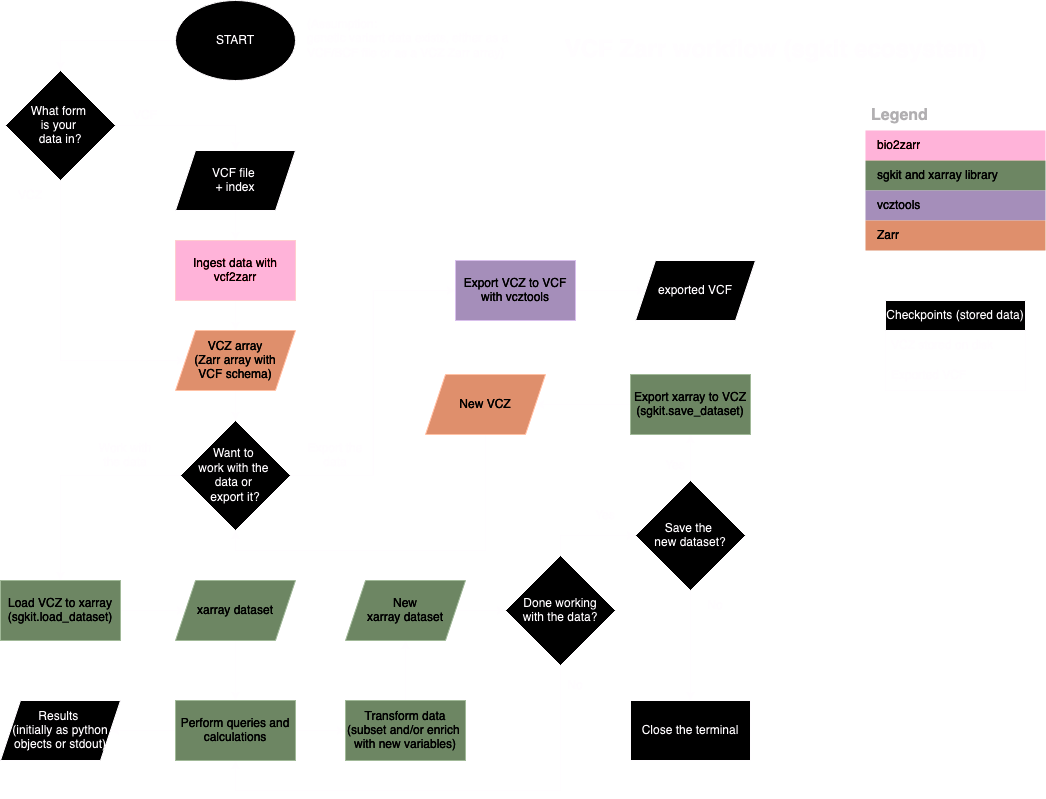

In [1]:
from IPython.display import Image
Image("./images/VCF_Zarr_data_flow_v1.drawio.png")

The figure tries to illustrate that most of the work is done with the `sgkit` and `xarray` libraries. The `zarr` python library is never used explicitly in this workflow (or in this notebook), but some `sgkit` functions seem to depend on it. Interestingly, the VCZ Zarr array itself is not operated on that much either: rather, it is loaded into memory as an xarray, and only if the user actively exports will it be written back to VCZ. It is thus makes sense to consider the VCZ arrary primarily as a data storage object. A data analysis loop could thus involve writing a new VCZ array at the end of each iteration over the analysis workflow (green symbols in the flow chart), if the user want to save the transformed dataset to disk. As the VCZ arrays will grow in number over a project life span, this will invevitably create a need for a data management strategy to keep track of all files and their metadata. This is not _per se_ supported by VCF Zarr. 

Another thing to keep in mind is that the user does not need to save the transformed data to disk as long as the commands used to generate the xarrays are documented and stored. Working in that manner will help keep the number of VCZ arrays down, but implicitly relies on that the speed of rerunning queries and transformations is not inhibitory.

## 1.2. Resources that aided and inspired various aspects of this notebook

- The [documentation for `sgkit`](https://sgkit-dev.github.io/sgkit/latest/)

- The [documentation for `bio2zarr`](https://sgkit-dev.github.io/bio2zarr/intro.html)

- The `vcf2zarr` [tutorial](https://sgkit-dev.github.io/bio2zarr/vcf2zarr/tutorial.html#sec-vcf2zarr-tutorial)

- `sgkit` [GWAS tutorial](https://github.com/sgkit-dev/sgkit/blob/7094d3cf192dfc25ff69456ec7f1e71e7df2c264/docs/examples/gwas_tutorial.ipynb) (contains examples of `vcf2zarr` operations) 

- An [older tutorial](http://alimanfoo.github.io/2017/06/14/read-vcf.html) that uses `scikit-allele` ([sgkit-predecessor that's no longer actively maintained](https://github.com/cggh/scikit-allel)) instead of `sgkit`

- The `bcftools` [manual](https://samtools.github.io/bcftools/bcftools.html)


# 2. Setup

The core VCF Zarr tools were installed with conda on a Mac M3 using the following:


```bash
CONDA_SUBDIR=osx-64 conda create -n vcf_zarr python=3.10 -y
conda activate vcf_zarr
conda install mamba -y
mamba install jupyter -y
mamba install -c conda-forge sgkit -y
mamba install bcftools -y 
pip install bio2zarr
pip install vcztools
```

`sgkit` contains the VCF Zarr specification, and installing with conda also installs `zarr`, `numpy`, `pandas`, `dask`, `xarrays`, and `CuPy`. `sgkit` has dependencies that require Python 3.10 and hence this needed to be specified for creating the environment. Note that `bio2zarr` (which contains the `vcf2zarr` method that we will be using to ingest VCFs) is installed in the env using pip since there is at the time of writing no conda channel that hosts it.


(During the work on this notebook, `vcztools` was made available from pypi (`pip install vcztools`), but the original draft of the notebook relied on a manual installation. Below are the notes for how to manually install the tool, should they be needed again. 


```bash
## Manual installation of vcztools and its dependencies (used to install v0.0.1a1)
pip install pyranges
pip install pyparsing
git clone https://github.com/sgkit-dev/vcztools.git
cd vcztools #Important to change dir in order for the next command to work!
python setup.py install
```
When this was first tested, `setup.py` raised an error about the pip distribution of `vcztools` but the tool was seemingly functional nevertheless.)


To load the libraries and test that the installation works, we can run:

In [50]:
import sys
import os
import sgkit as sg
import zarr
import numpy as np
import pandas as pd
import xarray as xr
import requests
import humanfriendly
from bio2zarr.vcf2zarr import vcz

#Check that Conda and the libraries are installed as expected:
print(f"Current Conda environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Current Python version: {sys.version}")
print(
    f"sgkit v{sg.__version__}\n"
    f"zarr v{zarr.__version__}\n"
    f"numpy v{np.__version__}\n"
    f"pandas v{pd.__version__}\n"
    f"xarray v{xr.__version__}"
)

!vcf2zarr --version
!bcftools --version
print("\nvcztools --help")
!vcztools --help

Current Conda environment: vcf_zarr
Current Python version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:12:04) [Clang 18.1.8 ]
sgkit v0.9.0
zarr v2.18.3
numpy v1.26.4
pandas v2.2.2
xarray v2025.1.2
vcf2zarr, version 0.1.2
bcftools 1.21
Using htslib 1.21
Copyright (C) 2024 Genome Research Ltd.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.

vcztools --help
Usage: vcztools [OPTIONS] COMMAND [ARGS]...

Options:
  --help  Show this message and exit.

Commands:
  index
  query
  view


# 3. Data ingestion

The first unit operation in the VCF Zarr workflow is to ingest the data from the VCF, effectivly populating a Zarr array according to VCF Zarr schema. Compared to just processing a VCF with `bcftools`, ingestion of data is an additional step that will come with an added cost of time and CPU and memory resources. For a user to migrate from `bcftools` to VCF Zarr, there should hopefully be other benefits that compensate for the overhead of data ingestions. Ideally, ingestion is a one-time operation per VCF file. We will return to the question of adding more data to a VCZ file in Part II (i.e. Notebook 3.2).

The documentation of `bio2zarr` does not explicitly mention that it supports BCF files, so we will start with the VCF.GZ file (Section 3.1) and then come back to test if it actually can take BCF files too (Section 3.2). We will use the example data prepared in Notebook 1 for testing. Assuming that the cells of that notebook have been run, the paths to the files will be:


In [51]:
downsampled_vcf_gz = "./input_data_temp/1kG_p3_chr1_first_200_samples_c1.vcf.gz"
downsampled_bcf="./input_data_temp/1kG_p3_chr1_first_200_samples_c1.bcf"

## 3.1. Ingestion of the downsampled VCF.GZ file

The [`vcf2zarr` tutorial](https://sgkit-dev.github.io/bio2zarr/vcf2zarr/tutorial.html#sec-vcf2zarr-tutorial) describes a three different methods to ingest data, suited for different datasizes and user customizability. `vcf2zarr convert`  handles the whole ingestion process with minimal need for parameter tweaking, but it is only reccomended for small datasets. The first line of [the docstring](https://sgkit-dev.github.io/bio2zarr/vcf2zarr/cli_ref.html#cmd-vcf2zarr-convert) highlights this:

> Convert input VCF(s) directly to vcfzarr (not recommended for large files).

This begs the question of what is considered a large file? Perhaps the downsampled example file is actaully small enough to see no differences in performance between the methods?

The second method is seemingly considered the standard method. It has no recommended limitations when it comes to dataset size. This method consists of two commands: `vcf2zarr explode` and `vcf2zarr encode`. The former generates an intermediate array that is converted to VCZ with the latter command which supports several optional parameters for customizing the final VCZ array.

The third method is for ingesting data at biobank scale, which seem to be a main motivation for the development of VCF Zarr. This is not applicable for the scope of this notebook, and thus it is only mentioned here for the sake of completion.

To learn if any of the first two methods are more efficient for the downsampled example data, let's try each of the them out in turn.

Ingestion of the downsampled file `1kG_p3_chr1_first_200_samples_c1.vcf.gz` using the `vcf2zarr convert` method works like this:

In [4]:
%%time
!vcf2zarr convert {downsampled_vcf_gz} intermediate_data_temp/1kg_downsample.vcz

    Scan: 100%|███████████████████████████| 1.00/1.00 [00:00<00:00, 2.10files/s]
 Explode: 100%|█████████████████████████| 1.33M/1.33M [05:21<00:00, 4.13kvars/s]
  Encode: 100%|████████████████████████████| 2.20G/2.20G [04:55<00:00, 7.46MB/s]
Finalise: 100%|███████████████████████████| 38.0/38.0 [00:08<00:00, 4.30array/s]
CPU times: user 6.1 s, sys: 1.64 s, total: 7.73 s
Wall time: 10min 45s


(kvars/s referes to the ingestion rate in 1000 variants per second)

Interestingly, the Zarr array is stored in exposed file structure (the variable arrays inside the subdirectories are compressed, though). As suggested by [the tutorial](https://sgkit-dev.github.io/bio2zarr/vcf2zarr/tutorial.html#sec-vcf2zarr-tutorial), the structure can be visualised with `tree` (here installed on MacOS with `brew install tree`, i.e. independent of the conda enviroment).

In [5]:
!tree intermediate_data_temp/1kg_downsample.vcz

intermediate_data_temp/1kg_downsample.vcz
├── call_genotype
│   ├── 0
│   │   └── 0
│   │       └── 0
│   ├── 1
│   │   └── 0
│   │       └── 0
│   ├── 10
│   │   └── 0
│   │       └── 0
│   ├── 100
│   │   └── 0
│   │       └── 0
│   ├── 1000
│   │   └── 0
│   │       └── 0
│   ├── 1001
│   │   └── 0
│   │       └── 0
│   ├── 1002
│   │   └── 0
│   │       └── 0
│   ├── 1003
│   │   └── 0
│   │       └── 0
│   ├── 1004
│   │   └── 0
│   │       └── 0
│   ├── 1005
│   │   └── 0
│   │       └── 0
│   ├── 1006
│   │   └── 0
│   │       └── 0
│   ├── 1007
│   │   └── 0
│   │       └── 0
│   ├── 1008
│   │   └── 0
│   │       └── 0
│   ├── 1009
│   │   └── 0
│   │       └── 0
│   ├── 101
│   │   └── 0
│   │       └── 0
│   ├── 1010
│   │   └── 0
│   │       └── 0
│   ├── 1011
│   │   └── 0
│   │       └── 0
│   ├── 1012
│   │   └── 0
│   │       └── 0
│   ├── 1013
│   │   └── 0
│   │       └── 0
│   ├── 1014
│   │   └── 0
│   │       └── 0
│   ├── 1015
│   │   └── 0
│   │       └── 0
│   ├

The `vcf2zarr inspect` command summarizes the VCZ. For the example data we are using here, the genotype calls take up the most space, which makes sense. 

In [6]:
!vcf2zarr inspect intermediate_data_temp/1kg_downsample.vcz

name                    dtype    stored      size          ratio    nchunks  chunk_size               avg_chunk_stored    shape              chunk_shape       compressor                                                      filters
----------------------  -------  ----------  ----------  -------  ---------  -----------------------  ------------------  -----------------  ----------------  --------------------------------------------------------------  ------------
/call_genotype          int8     22.26 MiB   506.15 MiB   23           1327  390.58 KiB               17.18 KiB           (1326846, 200, 2)  (1000, 10000, 2)  Blosc(cname='zstd', clevel=7, shuffle=BITSHUFFLE, blocksize=0)  None
/variant_id             object   5.47 MiB    10.12 MiB     1.9         1327  7.81 KiB                 4.22 KiB            (1326846,)         (1000,)           Blosc(cname='zstd', clevel=7, shuffle=NOSHUFFLE, blocksize=0)   [VLenUTF8()]
/variant_AF             float32  4.27 MiB    60.74 MiB    14         

The second method for data ingestion, which is reccomended for larger datasets, is based on calling `explode` to generate an “intermediate columnar format” (.icf) and in turn converting it to a VCZ array with the `encode` command. In addition to the claim that this method is better suited for larger datasets, another appeal with the `explode`-`encode` operation is that it allows to set custom parameters to a much larger extent than `convert` does.

In [7]:
%%time
!vcf2zarr explode {downsampled_vcf_gz} intermediate_data_temp/1kg_downsample.icf

    Scan: 100%|███████████████████████████| 1.00/1.00 [00:00<00:00, 1.96files/s]
 Explode: 100%|█████████████████████████| 1.33M/1.33M [05:51<00:00, 3.78kvars/s]
CPU times: user 3.04 s, sys: 841 ms, total: 3.88 s
Wall time: 5min 52s


By looking at the resulting directory we can learn that the subdirectories in the ICF directory are named after the original VCF column headings:

In [8]:
!ls intermediate_data_temp/1kg_downsample.icf

ALT    FILTERS	ID    POS   REF		metadata.json
CHROM  FORMAT	INFO  QUAL  header.txt	rlen


The inspect method gives slightly different output for the .icf than the .vcf we looked at above. The regular `!vcf2zarr inspect intermediate_data_temp/1kg_downsample.icf` prints a table to the terminal, but if we want to get easy access to the values in the table, we can convert the array to a Pandas dataframe with the `vcz` method imported from the `bio2zarr` python library.

In [9]:
icf_inspect = vcz.inspect("intermediate_data_temp/1kg_downsample.icf")
icf_inspect_df = pd.DataFrame(icf_inspect)
icf_inspect_df

name     type  chunks        size  compressed  max_n  \
0                CHROM   String       4  141.72 MiB   31.26 KiB      1   
1                  POS  Integer       4  141.72 MiB    2.41 MiB      1   
2                 QUAL    Float       4  141.72 MiB   23.23 KiB      1   
3                   ID   String       4  141.72 MiB    8.54 MiB      1   
4              FILTERS   String       4  161.97 MiB   44.92 KiB      1   
5                  REF   String       4  141.72 MiB    1.34 MiB      1   
6                  ALT   String       4  147.68 MiB    1.35 MiB     12   
7                 rlen  Integer       4  141.72 MiB  241.13 KiB      1   
8            FORMAT/GT  Integer      28    1.64 GiB   32.72 MiB      3   
9           INFO/CIEND  Integer       4    20.3 MiB     6.1 KiB      2   
10          INFO/CIPOS  Integer       4    20.3 MiB    6.06 KiB      2   
11             INFO/CS   String       4   20.38 MiB    8.01 KiB      1   
12            INFO/END  Integer       4    20.3 MiB    7.85 KiB      1   
13      INFO/IMPRECISE     Flag       4   20.25 MiB    1.37 KiB      1   
14             INFO/MC   String       4   20.26 MiB    3.42 KiB     14   
15         INFO/MEINFO   String       4   20.33 MiB    7.86 KiB      4   
16           INFO/MEND  Integer       4   20.25 MiB   627 bytes      0   
17           INFO/MLEN  Integer       4   20.25 MiB   627 bytes      0   
18         INFO/MSTART  Integer       4   20.25 MiB   627 bytes      0   
19          INFO/SVLEN  Integer       4   20.29 MiB    5.24 KiB      1   
20         INFO/SVTYPE   String       4   20.35 MiB    7.71 KiB      1   
21            INFO/TSD   String       4    20.3 MiB    8.19 KiB      1   
22             INFO/AC  Integer       4  142.01 MiB    1.78 MiB     12   
23             INFO/AF    Float       4  142.01 MiB    3.52 MiB     12   
24             INFO/NS  Integer       4  141.72 MiB   23.26 KiB      1   
25             INFO/AN  Integer       4  141.72 MiB   23.32 KiB      1   
26         INFO/EAS_AF    Float       4  142.01 MiB    2.26 MiB     12   
27         INFO/EUR_AF    Float       4  142.01 MiB    2.66 MiB     12   
28         INFO/AFR_AF    Float       4  142.01 MiB    2.62 MiB     12   
29         INFO/AMR_AF    Float       4  142.01 MiB    2.51 MiB     12   
30         INFO/SAS_AF    Float       4  142.01 MiB    2.47 MiB     12   
31             INFO/DP  Integer       4  141.72 MiB    2.76 MiB      1   
32             INFO/AA   String       4  159.13 MiB    1.62 MiB      1   
33             INFO/VT   String       4  157.88 MiB  318.51 KiB      2   
34      INFO/EX_TARGET     Flag       4    22.3 MiB   29.95 KiB      1   
35  INFO/MULTI_ALLELIC     Flag       4    21.9 MiB   39.28 KiB      1   

     min_val   max_val  
0        n/a       n/a  
1      1e+04   2.5e+08  
2      1e+02     1e+02  
3        n/a       n/a  
4        n/a       n/a  
5        n/a       n/a  
6        n/a       n/a  
7          1   2.9e+05  
8          0        12  
9     -5e+02     1e+03  
10    -1e+03     5e+02  
11       n/a       n/a  
12   7.6e+05   2.5e+08  
13         1         1  
14       n/a       n/a  
15       n/a       n/a  
16       n/a       n/a  
17       n/a       n/a  
18       n/a       n/a  
19   1.2e+02     6e+03  
20       n/a       n/a  
21       n/a       n/a  
22         0     4e+02  
23         0         1  
24   2.5e+03   2.5e+03  
25     4e+02     4e+02  
26         0         1  
27         0         1  
28         0         1  
29         0         1  
30         0         1  
31   1.3e+02   3.3e+06  
32       n/a       n/a  
33       n/a       n/a  
34         1         1  
35         1         1

This illustrates how the different fields of the VCF is stored in the ICF. We can for instance see that the genotype calls (`FORMAT/GT`)take up most of the space in this array. However, since it is an intermediate array, let's not look too much at the absolute numbers until we have finished converting it to a VCZ arrary

[The tutorial](https://sgkit-dev.github.io/bio2zarr/vcf2zarr/tutorial.html#sec-vcf2zarr-tutorial) explains that the array dimensions, min and max values are used for setting the parameters for the Zarr encoding. The tutorial also explains in detail how it is possible to customize which fields are encoded in the zarr arrary by writing a custom schema in JSON. There seem to be a lot to tweak here, with potential improvements in storage and performance. 

But for now, let's just continue with the default settings for the encode method. To be able to differentiate between the arrays ingested by `vcf2zarr convert` and `vcf2zarr encode`, let's call the latter `1kg.encode.vcf`.

In [10]:
%%time
!vcf2zarr encode intermediate_data_temp/1kg_downsample.icf intermediate_data_temp/1kg_downsample_default_encode.vcz

  Encode: 100%|████████████████████████████| 2.20G/2.20G [05:09<00:00, 7.10MB/s]
Finalise: 100%|███████████████████████████| 38.0/38.0 [00:08<00:00, 4.61array/s]
CPU times: user 3.41 s, sys: 924 ms, total: 4.34 s
Wall time: 5min 37s


In this case, the `convert` operation took 10 min 45s wall time, and the `explode` + `encode` alternative took 11 min 49 s. Other replicate runs (data not shown) took about 8 minutes for both operations. Thus it is likely that this dataset is considered too small to see any gains from using the latter option (especially since we used default settings). The status messages speak of GiB of (uncompressed) data being ingested, but how much disk space does the resulting VCZ directories take up?

A Python function to measure directory size based on walking through all sub-dirs and files in a directory:

In [52]:
def get_directory_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
    return total_size

Comparing the ingested arrarys to the original .vcf.gz show that the file size is smaller:

In [70]:
vcz_convert = "./intermediate_data_temp/1kg_downsample.vcz"
icf = "./intermediate_data_temp/1kg_downsample.icf"
vcz_explode = "./intermediate_data_temp/1kg_downsample_default_encode.vcz"
downsampled_vcf_gz = "./input_data_temp/1kG_p3_chr1_first_200_samples_c1.vcf.gz"
file_size_downsampled_vcf_gz = os.path.getsize(downsampled_vcf_gz)
print(f"{os.path.basename(icf)}\t{humanfriendly.format_size(get_directory_size(icf), binary=True)}")
print(f"{os.path.basename(vcz_convert)}\t{humanfriendly.format_size(get_directory_size(vcz_convert), binary=True)}")
print(f"{os.path.basename(vcz_explode)}\t{humanfriendly.format_size(get_directory_size(vcz_explode), binary=True)}")
print(f"{os.path.basename(downsampled_vcf_gz)}\t{humanfriendly.format_size(file_size_downsampled_vcf_gz, binary=True)}")

1kg_downsample.icf	69.46 MiB
1kg_downsample.vcz	62.97 MiB
1kg_downsample_default_encode.vcz	62.97 MiB
1kG_p3_chr1_first_200_samples_c1.vcf.gz	79.62 MiB


Interesting! It seems that the claims about Zarr storage efficiency check out, at least for this dataset. It is also clear that both VCZ arrays have the same size, according to this measurement. It makes sense, since we used default settings for the `encode` step. The ICF array is a temporary storage, so it can be disregarded in this comparison.

The compression level is not amazing, but for just using the default `encode` settings, it is not bad either:

In [25]:
compression_ratio_example_data = file_size_downsampled_vcf_gz / get_directory_size(vcz_explode)
print(f"The ingested VCZ (vcf2zarr explode-encode; default settings) is compressed {compression_ratio_example_data:.2f}x over the VCF.GZ")

The ingested VCZ (vcf2zarr explode-encode; default settings) is compressed 1.26x over the VCF.GZ


The VCZ array can be inspected in the same way as the ICF array:

In [53]:
vcz_inspect = vcz.inspect("./intermediate_data_temp/1kg_downsample_default_encode.vcz")
vcz_inspect_df = pd.DataFrame(vcz_inspect)
vcz_inspect_df

name    dtype      stored        size     ratio nchunks  \
0           /call_genotype     int8   22.26 MiB  506.15 MiB        23    1327   
1              /variant_id   object    5.47 MiB   10.12 MiB       1.9    1327   
2              /variant_AF  float32    4.27 MiB   60.74 MiB        14    1327   
3          /variant_AFR_AF  float32    3.29 MiB   60.74 MiB        18    1327   
4          /variant_EUR_AF  float32    3.21 MiB   60.74 MiB        19    1327   
5              /variant_DP    int32     3.1 MiB    5.06 MiB       1.6    1327   
6          /variant_AMR_AF  float32    3.09 MiB   60.74 MiB        20    1327   
7          /variant_SAS_AF  float32    3.01 MiB   60.74 MiB        20    1327   
8        /variant_position    int32    2.94 MiB    5.06 MiB       1.7    1327   
9          /variant_EAS_AF  float32    2.76 MiB   60.74 MiB        22    1327   
10         /variant_allele   object    2.45 MiB   131.6 MiB        54    1327   
11     /call_genotype_mask     bool    2.36 MiB  506.15 MiB   2.1e+02    1327   
12             /variant_AC    int16    1.94 MiB   30.37 MiB        16    1327   
13   /call_genotype_phased     bool     1.6 MiB  253.08 MiB   1.6e+02    1327   
14             /variant_AA   object    1.35 MiB   10.12 MiB       7.5    1327   
15             /variant_VT   object  560.48 KiB   20.25 MiB        37    1327   
16         /variant_length    int32   304.8 KiB    5.06 MiB        17    1327   
17         /variant_MEINFO   object  246.63 KiB   40.49 MiB   1.7e+02    1327   
18             /variant_MC   object  237.16 KiB  141.72 MiB   6.1e+02    1327   
19          /variant_CIEND    int16  225.08 KiB    5.06 MiB        23    1327   
20          /variant_CIPOS    int16  225.08 KiB    5.06 MiB        23    1327   
21         /variant_filter     bool  224.81 KiB    1.27 MiB       5.8    1327   
22  /variant_MULTI_ALLELIC     bool  137.39 KiB    1.27 MiB       9.4    1327   
23             /variant_CS   object  124.22 KiB   10.12 MiB        83    1327   
24      /variant_EX_TARGET     bool  121.72 KiB    1.27 MiB        11    1327   
25         /variant_SVTYPE   object  119.42 KiB   10.12 MiB        87    1327   
26            /variant_TSD   object  115.84 KiB   10.12 MiB        89    1327   
27            /variant_END    int32  101.87 KiB    5.06 MiB        51    1327   
28        /variant_quality  float32  100.36 KiB    5.06 MiB        52    1327   
29          /variant_SVLEN    int16   99.62 KiB    2.53 MiB        26    1327   
30             /variant_AN    int16   97.79 KiB    2.53 MiB        27    1327   
31             /variant_NS    int16   97.77 KiB    2.53 MiB        27    1327   
32      /variant_IMPRECISE     bool   96.56 KiB    1.27 MiB        13    1327   
33         /variant_contig     int8   96.55 KiB    1.27 MiB        13    1327   
34         /variant_MSTART     int8    96.5 KiB    1.27 MiB        13    1327   
35           /variant_MEND     int8    96.5 KiB    1.27 MiB        13    1327   
36           /variant_MLEN     int8   96.49 KiB    1.27 MiB        13    1327   
37        /variant_id_mask     bool   96.44 KiB    1.27 MiB        13    1327   
38           /region_index    int32   12.63 KiB    31.1 KiB       2.5       1   
39              /sample_id   object   860 bytes    1.56 KiB       1.9       1   
40          /contig_length    int64   820 bytes   688 bytes      0.84       1   
41              /contig_id   object   772 bytes   688 bytes      0.89       1   
42              /filter_id   object   604 bytes     8 bytes     0.013       1   

                 chunk_size avg_chunk_stored              shape  \
0                390.58 KiB        17.18 KiB  (1326846, 200, 2)   
1                  7.81 KiB         4.22 KiB         (1326846,)   
2                 46.87 KiB         3.29 KiB      (1326846, 12)   
3                 46.87 KiB         2.54 KiB      (1326846, 12)   
4                 46.87 KiB         2.48 KiB      (1326846, 12)   
5                  3.91 KiB         2.39 KiB         (1

Just like in the ICF version we saw earlier, we can clearly see the largest subarray for this dataset is the genotype calls (`call_genotype`). It occupies 22.26 MiB on in the VCZ arrary and contains 506 Mib of compressed data with a compression ratio of 23x. However, other subarrarys were compressed to a lesser degree, and when all subarrarys are taken together we would get the total compression level calculated above.

The benefit of having loaded the `vcz` function from the `bio2zarr.vcf2zarr` python library (see Section 2 above) is that we have a pandas dataframe that we can easily process further. Below follows a few relevant operations on this dataframe.

Zarr arrays work by distributing data across different chunks. The shape of the chunks can be set during the `encode` operation and there might be room for optimization of the array; the optimial settings are likely to be different for each dataset, though. If we want to calculate the total number of chunks from a given VCZ arary, we can do:

In [61]:
vcz_inspect_df['nchunks'] = vcz_inspect_df['nchunks'].astype(int)
vcz_inspect_df['nchunks'].sum()

50431

Several fields in the dataframe have units. Taking a cue from a [notebook from the VCF Zarr preprint](https://github.com/sgkit-dev/vcf-zarr-publication/blob/main/ofh_example/storage.ipynb), we can use the `humanfriendly` library to do conversions on the fly. The `parse_size` method converts a human-readable file size to bytes. 

(This [tutorial](https://sgkit-dev.github.io/bio2zarr/vcf2zarr/tutorial.html) clarifies that the `stored` column refers to the disk space of the compressed chunks, and the `size` column refers the the size of the uncompressed subarray.)

In [64]:
print(vcz_inspect_df['stored'][1])
humanfriendly.parse_size(vcz_inspect_df['stored'][1])

5.47 MiB


5735710

We can use this to convert all the fields in a column to bytes, sum them up, and then convert them back to a human readable format: 

In [72]:
total_size_bytes = sum(humanfriendly.parse_size(size) for size in vcz_inspect_df['stored'])
total_size_human_readable = humanfriendly.format_size(total_size_bytes, binary=True)

total_uncompressed_bytes = sum(humanfriendly.parse_size(size) for size in vcz_inspect_df['size'])
total_uncompressed_human_readable = humanfriendly.format_size(total_uncompressed_bytes, binary=True)

print(f"Total size of the compressed chunks: {total_size_human_readable}")
print(f"Total size of the uncompressed array: {total_uncompressed_human_readable}")

Total size of the compressed chunks: 66.75 MiB
Total size of the uncompressed array: 2.05 GiB


Comparing this to the storage size found by running the custom python function, the values are in the same ballpark, but different. It could be a matter of difference between the methods, it could be a matter of the VCZ being further compressed and that the sum of the chunks is not the same as the sum of the final files in the array directory.

In [71]:
print(f"{os.path.basename(vcz_convert)}\t{humanfriendly.format_size(get_directory_size(vcz_convert), binary=True)}")

1kg_downsample.vcz	62.97 MiB


At this point it is relevant to remember that the content of the variant calling data can differ from study to study, and as such the content and relative size of the variables in the VCZ will vary from dataset to dataset. Consider for instance the datasets used for the pre-print: the VCZ arrays [of their human UK dataset (Our Future Health project)](https://github.com/sgkit-dev/vcf-zarr-publication/blob/main/ofh_example/storage.ipynb), and the [spruce dataset](https://github.com/sgkit-dev/vcf-zarr-publication/blob/main/spruce_example/storage.ipynb) each have different variables in the top when sorted by size and have also achieved different degrees of compression. This shows the range of data types that can be stored within the VCF format, and furthermore implies that the case-to-case differences can make it challenging to make generalized statements about any VCF storage alternatives.

## 3.2. Ingestion of the BCF version of the downsampled data

The `bio2zarr`documentation only mentions that it can be used to convert VCF to Zarr array and there is no mention of support for the BCF binary VCF format. The only way to find out is to test.

In [18]:
%%time
!vcf2zarr convert input_data_temp/1kG_p3_chr1_first_200_samples_c1.bcf intermediate_data_temp/1kg_downsample_bcf_version.vcz

    Scan: 100%|███████████████████████████| 1.00/1.00 [00:00<00:00, 1.88files/s]
 Explode: 100%|█████████████████████████| 1.33M/1.33M [05:06<00:00, 4.33kvars/s]
  Encode: 100%|████████████████████████████| 2.20G/2.20G [04:56<00:00, 7.42MB/s]
Finalise: 100%|███████████████████████████| 38.0/38.0 [00:08<00:00, 4.47array/s]
CPU times: user 5.82 s, sys: 1.56 s, total: 7.39 s
Wall time: 10min 35s


Interestingly, it worked! The ingestion time is on par with the time it took to ingest the VCF.GZ version of the same dataset with the same command (`vcf2zarr convert`). This indicates that there are no performance wins by first converting the VCF.GZ to BCF when doing the ingestion to VCZ. That said, this has only been tested with one dataset and more testing would be needed to make a conclusion.

The file size of VCZ array was the same as before. This was expected since we ingested the exact same data, just in another form (BCF instead of VCF).

In [73]:
bcf_vcz = "./intermediate_data_temp/1kg_downsample_bcf_version.vcz"
print(f"{os.path.basename(bcf_vcz)}\t{humanfriendly.format_size(get_directory_size(bcf_vcz), binary=True)}")
vcz_inspect = vcz.inspect("./intermediate_data_temp/1kg_downsample_bcf_version.vcz")
vcz_inspect_bcf_df = pd.DataFrame(vcz_inspect)

total_size_bytes = sum(humanfriendly.parse_size(size) for size in vcz_inspect_bcf_df['stored'])
total_size_human_readable = humanfriendly.format_size(total_size_bytes, binary=True)

total_uncompressed_bytes = sum(humanfriendly.parse_size(size) for size in vcz_inspect_bcf_df['size'])
total_uncompressed_human_readable = humanfriendly.format_size(total_uncompressed_bytes, binary=True)

print(f"Total size of the compressed chunks: {total_size_human_readable}")
print(f"Total size of the uncompressed array: {total_uncompressed_human_readable}")
vcz_inspect_bcf_df

1kg_downsample_bcf_version.vcz	62.97 MiB
Total size of the compressed chunks: 66.75 MiB
Total size of the uncompressed array: 2.05 GiB


name    dtype      stored        size     ratio nchunks  \
0           /call_genotype     int8   22.26 MiB  506.15 MiB        23    1327   
1              /variant_id   object    5.47 MiB   10.12 MiB       1.9    1327   
2              /variant_AF  float32    4.27 MiB   60.74 MiB        14    1327   
3          /variant_AFR_AF  float32    3.29 MiB   60.74 MiB        18    1327   
4          /variant_EUR_AF  float32    3.21 MiB   60.74 MiB        19    1327   
5              /variant_DP    int32     3.1 MiB    5.06 MiB       1.6    1327   
6          /variant_AMR_AF  float32    3.09 MiB   60.74 MiB        20    1327   
7          /variant_SAS_AF  float32    3.01 MiB   60.74 MiB        20    1327   
8        /variant_position    int32    2.94 MiB    5.06 MiB       1.7    1327   
9          /variant_EAS_AF  float32    2.76 MiB   60.74 MiB        22    1327   
10         /variant_allele   object    2.45 MiB   131.6 MiB        54    1327   
11     /call_genotype_mask     bool    2.36 MiB  506.15 MiB   2.1e+02    1327   
12             /variant_AC    int16    1.94 MiB   30.37 MiB        16    1327   
13   /call_genotype_phased     bool     1.6 MiB  253.08 MiB   1.6e+02    1327   
14             /variant_AA   object    1.35 MiB   10.12 MiB       7.5    1327   
15             /variant_VT   object  560.48 KiB   20.25 MiB        37    1327   
16         /variant_length    int32   304.8 KiB    5.06 MiB        17    1327   
17         /variant_MEINFO   object  246.63 KiB   40.49 MiB   1.7e+02    1327   
18             /variant_MC   object  237.16 KiB  141.72 MiB   6.1e+02    1327   
19          /variant_CIEND    int16  225.08 KiB    5.06 MiB        23    1327   
20          /variant_CIPOS    int16  225.08 KiB    5.06 MiB        23    1327   
21         /variant_filter     bool  224.81 KiB    1.27 MiB       5.8    1327   
22  /variant_MULTI_ALLELIC     bool  137.39 KiB    1.27 MiB       9.4    1327   
23             /variant_CS   object  124.22 KiB   10.12 MiB        83    1327   
24      /variant_EX_TARGET     bool  121.72 KiB    1.27 MiB        11    1327   
25         /variant_SVTYPE   object  119.42 KiB   10.12 MiB        87    1327   
26            /variant_TSD   object  115.84 KiB   10.12 MiB        89    1327   
27            /variant_END    int32  101.87 KiB    5.06 MiB        51    1327   
28        /variant_quality  float32  100.36 KiB    5.06 MiB        52    1327   
29          /variant_SVLEN    int16   99.62 KiB    2.53 MiB        26    1327   
30             /variant_AN    int16   97.79 KiB    2.53 MiB        27    1327   
31             /variant_NS    int16   97.77 KiB    2.53 MiB        27    1327   
32      /variant_IMPRECISE     bool   96.56 KiB    1.27 MiB        13    1327   
33         /variant_contig     int8   96.55 KiB    1.27 MiB        13    1327   
34         /variant_MSTART     int8    96.5 KiB    1.27 MiB        13    1327   
35           /variant_MEND     int8    96.5 KiB    1.27 MiB        13    1327   
36           /variant_MLEN     int8   96.49 KiB    1.27 MiB        13    1327   
37        /variant_id_mask     bool   96.44 KiB    1.27 MiB        13    1327   
38           /region_index    int32   12.63 KiB    31.1 KiB       2.5       1   
39              /sample_id   object   860 bytes    1.56 KiB       1.9       1   
40          /contig_length    int64   820 bytes   688 bytes      0.84       1   
41              /contig_id   object   772 bytes   688 bytes      0.89       1   
42              /filter_id   object   604 bytes     8 bytes     0.013       1   

                 chunk_size avg_chunk_stored              shape  \
0                390.58 KiB        17.18 KiB  (1326846, 200, 2)   
1                  7.81 KiB         4.22 KiB         (1326846,)   
2                 46.87 KiB         3.29 KiB      (1326846, 12)   
3                 46.87 KiB         2.54 KiB      (1326846, 12)   
4                 46.87 KiB         2.48 KiB      (1326846, 12)   
5                  3.91 KiB         2.39 KiB         (1

# 4. Working with the data: queries, subsetting, filtering

## 4.1. How is the data organized and accessed in the xarray?
With the data ingested into a Zarr array, the next step in the VCF Zarr operations on the data is to load the data into an Xarray with `sgkit`. It is likely that the `Zarr` python library could be used as well for performing the operations that we will be looking at in this section, but for now let's use the tools that VCF Zarr was designed for. Loading the encoded zarr array to a "sgkit" dataset shows that it is an Xarray. 

In [3]:
%%time
ds = sg.load_dataset("./intermediate_data_temp/1kg_downsample_default_encode.vcz")
ds

CPU times: user 98 ms, sys: 51.9 ms, total: 150 ms
Wall time: 424 ms


<xarray.Dataset> Size: 2GB
Dimensions:                (variants: 1326846, samples: 200, ploidy: 2,
                            contigs: 86, filters: 1, region_index_values: 1327,
                            region_index_fields: 6, alt_alleles: 12,
                            INFO_CIEND_dim: 2, INFO_CIPOS_dim: 2,
                            INFO_MC_dim: 14, INFO_MEINFO_dim: 4,
                            INFO_VT_dim: 2, alleles: 13)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alt_alleles, INFO_CIEND_dim, INFO_CIPOS_dim,
                                INFO_MC_dim, INFO_MEINFO_dim, INFO_VT_dim,
                                alleles
Data variables: (12/43)
    call_genotype          (variants, samples, ploidy) int8 531MB dask.array<chunksize=(1000, 200, 2), meta=np.ndarray>
    call_genotype_mask     (variants, samples, ploidy) bool 531MB dask.array<chunksize=(1000, 200, 2), meta=np.ndarray>
    call_genotype_phased   (variants, samples) bool 265MB dask.array<chunksize=(1000, 200), meta=np.ndarray>
    contig_id              (contigs) object 688B dask.array<chunksize=(86,), meta=np.ndarray>
    contig_length          (contigs) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    filter_id              (filters) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                     ...
    variant_filter         (variants, filters) bool 1MB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    variant_id             (variants) object 11MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask        (variants) bool 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length         (variants) int32 5MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position       (variants) int32 5MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality        (variants) float32 5MB dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.2
    vcf_header:        ##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

Bascially, this converts the Zarr array to an Xarrary. But what is that, really? The [Xarray documentation](https://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html) explains that it is a library for enhancing `numpy` N-dimentional arrarys to improve label handling and label-based parsing of the array.

Loading and saving the Zarr array to an Xarrary is done with the `sgkit.load_dataset()`, and `sgkit.save_dataset()` commands, respectively. The means that if a user wants to export filtered and subset results, the Xarray dataset `ds` will need to be saved back to a Zarr array with`sgkit.save_dataset()` and then exported to VCF with `vcztools`. Exporting will be investigated in Section 5.

Many of the `sgkit` methods for acting on the data are either wrappers or direct calls for `xarrary` methods. For instance `sgkit.save_dataset()` is a wrapper for `xarray.open_zarr()`, and filtering of variants is used by `.sel` which is `xarray.Dataset.sel`. This is all well, but is not necessarily very beginner friendly.

As displayed in the previous output where we called `ds`, there are a number of variables that can be accessed (in this case there are 41). A definition of all VCZ variables [are found here](https://sgkit-dev.github.io/sgkit/latest/api.html#api-variables). Calling a variable will result in an overview of that subarray:

In [38]:
%%time
ds.call_genotype

CPU times: user 109 μs, sys: 2 μs, total: 111 μs
Wall time: 116 μs


<xarray.DataArray 'call_genotype' (variants: 1326846, samples: 200, ploidy: 2)> Size: 531MB
dask.array<open_dataset-call_genotype, shape=(1326846, 200, 2), dtype=int8, chunksize=(1000, 200, 2), chunktype=numpy.ndarray>
Dimensions without coordinates: variants, samples, ploidy
Attributes:
    description:

To view the underlying data, the `.value` method needs to be chained to the variable method. The docs warn that using `.values` will bring the values to memory and [that this is only suitable for small datasets](https://sgkit-dev.github.io/sgkit/latest/how_do_i.html#get-the-values-for-a-variable-in-a-dataset). 

In general VCF filtering is not typically done by row number (we will get into more relevant filtering cases later), but for the sake of illustration, let's first slice out the genotype calls from first variant from the first 10 samples. This results in a summary of the `call_genotype` variable with our slicing applied: 

In [37]:
%%time
ds.call_genotype[:1, :10]

CPU times: user 932 μs, sys: 1e+03 ns, total: 933 μs
Wall time: 946 μs


<xarray.DataArray 'call_genotype' (variants: 1, samples: 10, ploidy: 2)> Size: 20B
dask.array<getitem, shape=(1, 10, 2), dtype=int8, chunksize=(1, 10, 2), chunktype=numpy.ndarray>
Dimensions without coordinates: variants, samples, ploidy
Attributes:
    description:

If we want to view the values (here: the genotypes from the ten samples) from this variant we can chain an additional method to the call. The positions in `call_genotype` are zero-indexed, so to get the first variant for the first ten samples, we can do:

In [87]:
%%time
ds.call_genotype[0, :10].values

CPU times: user 27.7 ms, sys: 3.27 ms, total: 31 ms
Wall time: 27.7 ms


array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 0]], dtype=int8)

Displaying the first two variants in this manner would hence look like this:

In [35]:
%%time
ds.call_genotype[:2, :10].values

CPU times: user 24 ms, sys: 4.08 ms, total: 28 ms
Wall time: 26.4 ms


array([[[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0]],

       [[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 1],
        [0, 0]]], dtype=int8)

This `values` method in facts converts the (subset) of the Xarrary into a numpy arrary, as is indicated by the look of the output and confirmed by:

In [29]:
type(ds.call_genotype[:1, :10].values)

numpy.ndarray

Instead of chaining methods, we could of course have have declared new variables along the way, such as:

```python
genotypes_variant1_samples_1_to_10 = ds.call_genotype[:1, :10]
genotypes_variant1_samples_1_to_10.values
```

Depending on your style of coding, you might prefer this over method chaining. However, as we will see later on, for many of the queries and operations that we will test, there will actually be quite a number if methods that need to be combined to perform a single operation. The [sgkit "Getting Started" guide](https://sgkit-dev.github.io/sgkit/latest/getting_started.html#chaining-operations) recommends that method chaining is use, so for the remained of the notebook we will stick to that.

For a sanity-check, let's compare these results from the VCZ with the data from the original vcf.gz file. If we want to extract the first variant from the file, a pipe with `gzcat` and `awk` is likely going to be faster than `bcftools` (seeing that VCF filtering is seldom done by row number but by other parameters).

In [31]:
%%time
!gzcat input_data_temp/1kG_p3_chr1_first_200_samples_c1.vcf.gz 2>/dev/null | awk '!/^#/ {print; count++; if (count==1) exit}'

1	10177	rs367896724	A	AC	100	PASS	AC=116;AF=0.425319;AN=400;NS=2504;DP=103152;EAS_AF=0.3363;AMR_AF=0.3602;AFR_AF=0.4909;EUR_AF=0.4056;SAS_AF=0.4949;AA=|||unknown(NO_COVERAGE);VT=INDEL	GT	1|0	0|1	0|1	1|0	0|0	1|0	1|0	1|0	1|0	0|0	0|0	0|0	0|0	0|0	0|0	0|0	0|1	1|0	0|0	0|0	1|0	0|0	0|0	0|0	0|1	1|0	0|1	0|1	0|1	0|1	1|0	0|0	1|0	1|0	0|0	0|1	0|0	0|0	1|0	0|1	1|0	0|0	1|0	1|0	0|0	1|0	0|1	0|1	0|0	0|0	1|0	1|0	0|0	0|0	0|1	0|0	0|0	1|0	1|1	1|0	0|1	0|0	0|0	1|1	0|1	0|0	0|1	0|1	0|0	1|0	1|0	1|0	0|1	0|0	1|0	1|0	1|0	0|0	1|0	0|0	0|1	0|1	1|0	0|1	1|1	0|0	0|1	0|0	1|0	0|0	0|0	1|0	0|0	0|0	0|0	1|0	1|0	0|0	0|1	0|0	1|0	0|0	1|0	0|1	1|0	0|1	0|1	0|1	1|0	1|0	0|0	0|0	0|0	0|0	0|0	1|0	0|1	0|0	0|0	0|0	0|1	1|0	1|0	1|0	1|0	1|0	0|0	0|1	0|1	0|0	0|0	0|0	0|0	1|0	0|1	0|0	0|0	0|0	0|1	0|1	1|0	0|0	0|0	0|0	1|0	0|0	1|0	0|0	0|1	0|1	0|0	0|0	0|1	0|0	1|0	0|0	0|1	1|0	0|1	0|0	1|0	1|0	0|0	0|1	1|1	0|0	1|1	0|1	0|0	1|0	1|0	0|1	0|0	0|1	0|0	0|0	0|0	0|0	0|0	0|0	0|1	0|0	0|0	0|0	0|1	0|1	1|0	0|1	0|0	0|0	0|1	1|0	0|0	0|0	1|0	0|0	1|0	0|0	0|0	0|0
CPU times: us

(`2>/dev/null` is to silence a _broken pipe_ error that occurs when running the pipe in Jupyter. The error did not occur when running it in the terminal)

The genotype calls from the first ten samples indeed match the results of the subsetting of the `ds`. If we want to extract just the results of 10 first samples, the `awk` command does becomes a little unwieldy, it makes the output easier to compare with `ds.call_genotype[:1, :10].values`

In [32]:
!gzcat input_data_temp/1kG_p3_chr1_first_200_samples_c1.vcf.gz 2>/dev/null |awk '!/^#/ {print $10, $11, $12, $13, $14, $15, $16, $17, $18, $19; count++; if (count == 1) exit}'

1|0 0|1 0|1 1|0 0|0 1|0 1|0 1|0 1|0 0|0


In [75]:
ds.call_genotype[:1, :10].values

array([[[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0]]], dtype=int8)

Another benefit of printing the whole line of first variant with `awk`, 200 samples and all, we learned its contig name (1; as in chromosome 1), its coordinate (10177), and its ID (rs367896724). We will return to how these values can be used for filtering in the sections below.

## 4.2 Subsetting on a genomic range
Subsetting on a genomic coordinate, or a range of coordinates is supported, but has a rather cumbersome syntax. The developers themselves [point that out in the docs](https://sgkit-dev.github.io/sgkit/latest/how_do_i.html#subset-to-a-genomic-range). The currently recommended way of doing this is to define an index that we want to filter over and select for a desired range in the new index. In our current example data, we only have one scaffold (chromosome 1) we can just tell that the new index should be based on the variable `variant_position`. From looking a the downsampled VCF, e.g. using

`!gzcat input_data_temp/1kG_p3_chr1_first_200_samples_c1.vcf.gz 2>/dev/null | awk '!/^#/ {print; count++; if (count==2) exit}'`.

we can learn that the second variant occurs in position 10352 on chr1 Let's use that as our range for filtering on the new index (`slice(10177, 10352)`), and expect to get two variants in the output. 

In [76]:
%%time
#Set a new index based on the variant_position variable in the variants dimension, then select a slice from the reindexd dimension
ds.set_index(variants=("variant_position")).sel(variants=(slice(10177, 10352)))

CPU times: user 352 ms, sys: 176 ms, total: 528 ms
Wall time: 443 ms


<xarray.Dataset> Size: 38kB
Dimensions:                (variants: 2, samples: 200, ploidy: 2, contigs: 86,
                            filters: 1, region_index_values: 1327,
                            region_index_fields: 6, alt_alleles: 12,
                            INFO_CIEND_dim: 2, INFO_CIPOS_dim: 2,
                            INFO_MC_dim: 14, INFO_MEINFO_dim: 4,
                            INFO_VT_dim: 2, alleles: 13)
Coordinates:
  * variants               (variants) int32 8B 10177 10352
Dimensions without coordinates: samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alt_alleles, INFO_CIEND_dim, INFO_CIPOS_dim,
                                INFO_MC_dim, INFO_MEINFO_dim, INFO_VT_dim,
                                alleles
Data variables: (12/42)
    call_genotype          (variants, samples, ploidy) int8 800B dask.array<chunksize=(2, 200, 2), meta=np.ndarray>
    call_genotype_mask     (variants, samples, ploidy) bool 800B dask.array<chunksize=(2, 200, 2), meta=np.ndarray>
    call_genotype_phased   (variants, samples) bool 400B dask.array<chunksize=(2, 200), meta=np.ndarray>
    contig_id              (contigs) object 688B dask.array<chunksize=(86,), meta=np.ndarray>
    contig_length          (contigs) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    filter_id              (filters) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                     ...
    variant_contig         (variants) int8 2B dask.array<chunksize=(2,), meta=np.ndarray>
    variant_filter         (variants, filters) bool 2B dask.array<chunksize=(2, 1), meta=np.ndarray>
    variant_id             (variants) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    variant_id_mask        (variants) bool 2B dask.array<chunksize=(2,), meta=np.ndarray>
    variant_length         (variants) int32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    variant_quality        (variants) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.2
    vcf_header:        ##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

Two variants turn up, as expected. As the `xarray.Dataset` summary shows, there are 40 variables related to this genomic range: these are all the different fields from the VCF related to the variants in this range. We have sucessfully created a subset of the data that covers this short genomic range.

To view the genotypes, we can continue chaining the genotype calls of the first ten samples of the `call_genotypes` variable. To see all variants, we use `:` in the first position of positional bracket. 

In [80]:
%%time
ds.set_index(variants=("variant_position")).sel(variants=(slice(10177, 10352))).call_genotype[:,:10].values

CPU times: user 322 ms, sys: 156 ms, total: 478 ms
Wall time: 363 ms


array([[[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0]],

       [[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 1],
        [0, 0]]], dtype=int8)

Looks about right. Let's compare it to the corresponding values from the VCF:

In [46]:
%%time
!gzcat input_data_temp/1kG_p3_chr1_first_200_samples_c1.vcf.gz 2>/dev/null |awk '!/^#/ {print $10, $11, $12, $13, $14, $15, $16, $17, $18, $19; count++; if (count == 2) exit}'

1|0 0|1 0|1 1|0 0|0 1|0 1|0 1|0 1|0 0|0
1|0 1|0 0|1 0|1 1|0 1|0 1|0 0|0 0|1 0|0
CPU times: user 3.67 ms, sys: 19 ms, total: 22.7 ms
Wall time: 162 ms


Side-note: if there had been multiple scaffolds in the VCF dataset, the command would need to include the `variant_contig` variable in the new index and then include it in the `.sel` method. For demonstration purposes, we can apply the syntax here can make a call for the first scaffold in "variant_contig":

In [47]:
%%time
ds.set_index(variants=("variant_contig", "variant_position")).sel(variants=(0, slice(10177, 10352))).call_genotype[:,:10].values

CPU times: user 695 ms, sys: 448 ms, total: 1.14 s
Wall time: 802 ms


array([[[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0]],

       [[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 1],
        [0, 0]]], dtype=int8)

We can also access a single coordinate by making the selection on a single value instead of a xarrary slice
(cf `ds.set_index(variants=("variant_position")).sel(variants=(slice(10177, 10352)))`)

In [48]:
%%time
ds.set_index(variants=("variant_position")).sel(variants=(10177)).call_genotype[:10].values

CPU times: user 321 ms, sys: 213 ms, total: 534 ms
Wall time: 353 ms


array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 0]], dtype=int8)

## 4.3 Subsetting on sample names


Subsetting a variant dataset based on a list of sample names is a common VCF operation (in fact, we used it during the downsampling step where we extracted only the 200 first samples of the VCF). How to do this with `sgkit` is well covered in the [docs](https://sgkit-dev.github.io/sgkit/latest/how_do_i.html#subset-the-samples).

The names of all the samples in the dataset (here: 200 samples) can be listed by:

In [49]:
%%time
ds.sample_id.values

CPU times: user 9.71 ms, sys: 3.53 ms, total: 13.2 ms
Wall time: 17.8 ms


array(['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102',
       'HG00103', 'HG00105', 'HG00106', 'HG00107', 'HG00108', 'HG00109',
       'HG00110', 'HG00111', 'HG00112', 'HG00113', 'HG00114', 'HG00115',
       'HG00116', 'HG00117', 'HG00118', 'HG00119', 'HG00120', 'HG00121',
       'HG00122', 'HG00123', 'HG00125', 'HG00126', 'HG00127', 'HG00128',
       'HG00129', 'HG00130', 'HG00131', 'HG00132', 'HG00133', 'HG00136',
       'HG00137', 'HG00138', 'HG00139', 'HG00140', 'HG00141', 'HG00142',
       'HG00143', 'HG00145', 'HG00146', 'HG00148', 'HG00149', 'HG00150',
       'HG00151', 'HG00154', 'HG00155', 'HG00157', 'HG00158', 'HG00159',
       'HG00160', 'HG00171', 'HG00173', 'HG00174', 'HG00176', 'HG00177',
       'HG00178', 'HG00179', 'HG00180', 'HG00181', 'HG00182', 'HG00183',
       'HG00185', 'HG00186', 'HG00187', 'HG00188', 'HG00189', 'HG00190',
       'HG00231', 'HG00232', 'HG00233', 'HG00234', 'HG00235', 'HG00236',
       'HG00237', 'HG00238', 'HG00239', 'HG00240', 

What the docs failed to mention in for this operation is that sometimes the xarrary `.compute()` methods needs to be added to the selected index in order to avoid an error. (They cover it in another [use-case discussed elsewhere in the docs](https://sgkit-dev.github.io/sgkit/latest/how_do_i.html#filter-variants)). 

If we want to subset on two samples based on their names, we can for instance use the following for the two samples named `HG00096` and `HG00097`:

In [104]:
%%time
ds.sel(samples=ds.sample_id.isin(["HG00096", "HG00097"]).compute())

CPU times: user 23.1 ms, sys: 8.8 ms, total: 31.9 ms
Wall time: 29.5 ms


<xarray.Dataset> Size: 882MB
Dimensions:                (variants: 1326846, samples: 2, ploidy: 2,
                            contigs: 86, filters: 1, alt_alleles: 12,
                            INFO_CIEND_dim: 2, INFO_CIPOS_dim: 2,
                            INFO_MC_dim: 14, INFO_MEINFO_dim: 4,
                            INFO_VT_dim: 2, alleles: 13)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                alt_alleles, INFO_CIEND_dim, INFO_CIPOS_dim,
                                INFO_MC_dim, INFO_MEINFO_dim, INFO_VT_dim,
                                alleles
Data variables: (12/41)
    call_genotype          (variants, samples, ploidy) int8 5MB dask.array<chunksize=(10000, 2, 2), meta=np.ndarray>
    call_genotype_mask     (variants, samples, ploidy) bool 5MB dask.array<chunksize=(10000, 2, 2), meta=np.ndarray>
    call_genotype_phased   (variants, samples) bool 3MB dask.array<chunksize=(10000, 2), meta=np.ndarray>
    contig_id              (contigs) object 688B dask.array<chunksize=(86,), meta=np.ndarray>
    contig_length          (contigs) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    filter_id              (filters) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                     ...
    variant_contig         (variants) int8 1MB dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_filter         (variants, filters) bool 1MB dask.array<chunksize=(10000, 1), meta=np.ndarray>
    variant_id             (variants) object 11MB dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id_mask        (variants) bool 1MB dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position       (variants) int32 5MB dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_quality        (variants) float32 5MB dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.1
    vcf_header:        ##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

Sanity-check that the subset only contains the two desired samples:

In [50]:
%%time
ds.sel(samples=ds.sample_id.isin(["HG00096", "HG00097"]).compute()).sample_id.values

CPU times: user 44.4 ms, sys: 5.86 ms, total: 50.2 ms
Wall time: 48.3 ms


array(['HG00096', 'HG00097'], dtype=object)

Two things that are directly noticable are 
1) the complex syntax, and
2) the speed (it was instantaneus).

How long it would take for `bcftools` to extract the data from the two samples, either from the BCF or from the VCF version of the downsampled data:

In [90]:
%%time
!bcftools view -s HG00096,HG00097 --no-header {downsampled_bcf} 2>/dev/null  | head -n 1

1	10177	rs367896724	A	AC	100	PASS	AC=2;AF=0.425319;AN=4;NS=2504;DP=103152;EAS_AF=0.3363;AMR_AF=0.3602;AFR_AF=0.4909;EUR_AF=0.4056;SAS_AF=0.4949;AA=|||unknown(NO_COVERAGE);VT=INDEL	GT	1|0	0|1
CPU times: user 3.5 ms, sys: 72.2 ms, total: 75.7 ms
Wall time: 250 ms


In [105]:
%%time
!bcftools view -s HG00096,HG00097 --no-header {downsampled_vcf_gz} 2>/dev/null | head -n 1

1	10177	rs367896724	A	AC	100	PASS	AC=2;AF=0.425319;AN=4;NS=2504;DP=103152;EAS_AF=0.3363;AMR_AF=0.3602;AFR_AF=0.4909;EUR_AF=0.4056;SAS_AF=0.4949;AA=|||unknown(NO_COVERAGE);VT=INDEL	GT	1|0	0|1
CPU times: user 5.3 ms, sys: 49.6 ms, total: 54.9 ms
Wall time: 221 ms


Hmm, for this particular use-case, VCF Zarr was faster than `bcftools`. It was about one order of magnitude faster in terms of wall time than `bcftools`. It would be very interesting to test this at scale. However, we should be very careful not to extrapolate or draw any conclusions from this. To be able to do that, we would need to run this test with a much larger dataset.

## 4.4. Subsetting on a variant ID
Now that we have started to get a hang of the way the xarray dataset is accessed, coming up with commands to perform operations that are not explicitly stated in the `sgkit`documentation can be done. 

If we want to get a single variant of a range of consequtive variants, we make a new index and filter based on values that are relevant to that index. Then we can call the values from the subset, for instance the genotype values.

Let's say that we know that we want to access certain variant based on its variant ID, we can a subset a single variant with:

In [51]:
%%time
ds.set_index(variants=("variant_id")).sel(variants=("rs367896724")).call_genotype[:10].values

CPU times: user 781 ms, sys: 244 ms, total: 1.02 s
Wall time: 844 ms


array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 0]], dtype=int8)

If we want to get multple variants by name, we will need to figure out how to do call that from the xarray. [It turns out](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.isin.html) that we can use the `isin` method used to get sample names:

In [52]:
%%time
ds.sel(variants=ds.variant_id.isin(["rs367896724", "rs376342519"]).compute())

CPU times: user 948 ms, sys: 270 ms, total: 1.22 s
Wall time: 972 ms


<xarray.Dataset> Size: 38kB
Dimensions:                (variants: 2, samples: 200, ploidy: 2, contigs: 86,
                            filters: 1, region_index_values: 1327,
                            region_index_fields: 6, alt_alleles: 12,
                            INFO_CIEND_dim: 2, INFO_CIPOS_dim: 2,
                            INFO_MC_dim: 14, INFO_MEINFO_dim: 4,
                            INFO_VT_dim: 2, alleles: 13)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alt_alleles, INFO_CIEND_dim, INFO_CIPOS_dim,
                                INFO_MC_dim, INFO_MEINFO_dim, INFO_VT_dim,
                                alleles
Data variables: (12/43)
    call_genotype          (variants, samples, ploidy) int8 800B dask.array<chunksize=(2, 200, 2), meta=np.ndarray>
    call_genotype_mask     (variants, samples, ploidy) bool 800B dask.array<chunksize=(2, 200, 2), meta=np.ndarray>
    call_genotype_phased   (variants, samples) bool 400B dask.array<chunksize=(2, 200), meta=np.ndarray>
    contig_id              (contigs) object 688B dask.array<chunksize=(86,), meta=np.ndarray>
    contig_length          (contigs) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    filter_id              (filters) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                     ...
    variant_filter         (variants, filters) bool 2B dask.array<chunksize=(2, 1), meta=np.ndarray>
    variant_id             (variants) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    variant_id_mask        (variants) bool 2B dask.array<chunksize=(2,), meta=np.ndarray>
    variant_length         (variants) int32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    variant_position       (variants) int32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    variant_quality        (variants) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.2
    vcf_header:        ##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

Side-note: it turns out that `variants` in `ds.sel(variants=` has a defined meaning. It is just not a new name for an index that can take on any string value. For instance, if we were to call it `samples` instead of `variants`, it will raise an error. The reason for this is that each variable is associated with a higher level keyword (called `dimensions` in the xarray schema). If we display the dataset summary again and look at the Data Variables tab, we can see that each variable belongs to one of more dimensions. For instance, `call_genotype` belongs to `variants, samples, ploidy` (this is also laid our in the [API documentation for this variable](https://sgkit-dev.github.io/sgkit/latest/generated/sgkit.variables.call_genotype_spec.html#sgkit.variables.call_genotype_spec)). 

We can also access the Data Variables with `ds.data_vars`. To clean up the output to only print the variable name and its associated dimensions, we can iterate like so:

In [115]:
for var_name, var_data in ds.data_vars.items():
    print(f"{var_name}\t{var_data.dims}")

call_genotype	('variants', 'samples', 'ploidy')
call_genotype_mask	('variants', 'samples', 'ploidy')
call_genotype_phased	('variants', 'samples')
contig_id	('contigs',)
contig_length	('contigs',)
filter_id	('filters',)
region_index	('region_index_values', 'region_index_fields')
sample_id	('samples',)
variant_AA	('variants',)
variant_AC	('variants', 'alt_alleles')
variant_AF	('variants', 'alt_alleles')
variant_AFR_AF	('variants', 'alt_alleles')
variant_AMR_AF	('variants', 'alt_alleles')
variant_AN	('variants',)
variant_CIEND	('variants', 'INFO_CIEND_dim')
variant_CIPOS	('variants', 'INFO_CIPOS_dim')
variant_CS	('variants',)
variant_DP	('variants',)
variant_EAS_AF	('variants', 'alt_alleles')
variant_END	('variants',)
variant_EUR_AF	('variants', 'alt_alleles')
variant_EX_TARGET	('variants',)
variant_IMPRECISE	('variants',)
variant_MC	('variants', 'INFO_MC_dim')
variant_MEINFO	('variants', 'INFO_MEINFO_dim')
variant_MEND	('variants',)
variant_MLEN	('variants',)
variant_MSTART	('variants',)

If we want to learn the dimensions of a specific variable, we can call it from the xarray and add the `.dims` method:

In [118]:
ds.call_genotype.dims

('variants', 'samples', 'ploidy')

Another digression: if we, for some reason, would like to subset a range betwen two variant IDs, it is possible. Perhaps it is not very useful for any real-life case, but for the sake of understanding how the xarrary operations work, we can try it. The logic follows the same principles as when subsetting a range of coordinates. However, to get any useful results back from such queries, the user will of course need to know how the IDs are sorted in order for the slice operation to work. If the command below is done with a reverse order for `slice("rs376342519", "rs367896724")`, the result will be empty since that range does not exist in this datasest.

In [54]:
%%time
ds.set_index(variants=("variant_id")).sel(variants=(slice("rs367896724","rs376342519"))).call_genotype[:,:10].values

CPU times: user 670 ms, sys: 225 ms, total: 895 ms
Wall time: 698 ms


array([[[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0]],

       [[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 1],
        [0, 0]],

       [[1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]]], dtype=int8)

## 4.5. Subsetting based on variables

If we would like to make a subset that only includes a specific set of variables, we can apply Pandas-style slicing:

In [121]:
%%time
ds[["variant_contig", "variant_position", "variant_allele"]]

CPU times: user 162 μs, sys: 74 μs, total: 236 μs
Wall time: 246 μs


<xarray.Dataset> Size: 145MB
Dimensions:           (variants: 1326846, alleles: 13)
Dimensions without coordinates: variants, alleles
Data variables:
    variant_contig    (variants) int8 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position  (variants) int32 5MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_allele    (variants, alleles) object 138MB dask.array<chunksize=(1000, 13), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.2
    vcf_header:        ##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

This leads to the realization that for simple queries were we are basically extracting a single variably anyway, we can do Pandas-style slicing as an alternative. For instance, one of the first commands we tried

`ds.call_genotype[:1, :10].values`

gives the same results as: 

In [123]:
ds["call_genotype"][:1, :10].values

array([[[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0]]], dtype=int8)

Of course, we cannot use `ds["call_genotype"]` as an alternative to  `.call_genotype` in an example like this:

`ds.set_index(variants=("variant_id")).sel(variants=(slice("rs367896724","rs376342519"))).call_genotype[:,:10].values`

since the order of the operations will break the chain. (We cannot set a new index based on the variable `variant_id` if we first slice the dataset on call `call_genotype` with `ds["call_genotype"]`). This command will thus not work:

In [128]:
ds["call_genotype"].set_index(variants=("variant_id")).sel(variants=(slice("rs367896724","rs376342519"))).values`

SyntaxError: invalid syntax (855444062.py, line 1)

## 4.6 Subset on variant type (e.g. all INDELs)
Subsetting on variant type turned out to be a little more complex. The indexing method used in the previous examples cannot be applied here since it requires unique values to index over. The variant types, however, are recurring classifiers such as INDEL, SNP, CNV, SV. To perform this query, another xarray operation is needed

In [137]:
ds.variant_VT[:10].values

array([['INDEL', ''],
       ['INDEL', ''],
       ['INDEL', ''],
       ['SNP', ''],
       ['SNP', ''],
       ['SNP', ''],
       ['SNP', ''],
       ['SNP', ''],
       ['SNP', ''],
       ['SNP', '']], dtype=object)

As inspecting the values showed, this array has two columns (at least in this dataset). The second colum seem to be empty, but we cannot assume that it always will be. There is a [method in the xarrarys library](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.any.html) called `.any()` that can be used to check for a query in multiple columns of an array. In this case `variant_VT` is associated with `INFO_VT_dim` which contain two dimensions (as is shown by running `ds.INFO_VT_dim`). 

Technically, this becomes a boolean mask that checks if "INDEL" evaluates as true or false for each variant in all dimensions `INFO_VT_dim` of the variable `variant_VT`. Then we use `.sel` to select the variants that fulfil the boolean mask. The resulting dataset is a subset (as desired) and not a masked datasets of the original size.

In [178]:
%%time
indel_mask = (ds['variant_VT'] == 'INDEL').any(dim='INFO_VT_dim').compute()
ds_indels = ds.isel(variants=indel_mask)
ds_indels

CPU times: user 4.77 s, sys: 348 ms, total: 5.12 s
Wall time: 4.97 s


<xarray.Dataset> Size: 200MB
Dimensions:                (variants: 120706, samples: 200, ploidy: 2,
                            contigs: 86, filters: 1, region_index_values: 1327,
                            region_index_fields: 6, alt_alleles: 12,
                            INFO_CIEND_dim: 2, INFO_CIPOS_dim: 2,
                            INFO_MC_dim: 14, INFO_MEINFO_dim: 4,
                            INFO_VT_dim: 2, alleles: 13)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alt_alleles, INFO_CIEND_dim, INFO_CIPOS_dim,
                                INFO_MC_dim, INFO_MEINFO_dim, INFO_VT_dim,
                                alleles
Data variables: (12/43)
    call_genotype          (variants, samples, ploidy) int8 48MB dask.array<chunksize=(999, 200, 2), meta=np.ndarray>
    call_genotype_mask     (variants, samples, ploidy) bool 48MB dask.array<chunksize=(999, 200, 2), meta=np.ndarray>
    call_genotype_phased   (variants, samples) bool 24MB dask.array<chunksize=(999, 200), meta=np.ndarray>
    contig_id              (contigs) object 688B dask.array<chunksize=(86,), meta=np.ndarray>
    contig_length          (contigs) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    filter_id              (filters) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                     ...
    variant_filter         (variants, filters) bool 121kB dask.array<chunksize=(999, 1), meta=np.ndarray>
    variant_id             (variants) object 966kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask        (variants) bool 121kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length         (variants) int32 483kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position       (variants) int32 483kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality        (variants) float32 483kB dask.array<chunksize=(999,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.2
    vcf_header:        ##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

According to these results, 120,706 out of 1,326,846 variants are INDELs.

As a sanity-check we should also use `bcftools` to count the INDELS. Note that in order to get comparible results, we need to filter on INFO/VT="INDEL" also for the bcftools operation. 

In [290]:
%%time
!bcftools view --no-header -i 'INFO/VT="INDEL"' {downsampled_bcf} | wc -l

120706
CPU times: user 11.7 ms, sys: 26.8 ms, total: 38.4 ms
Wall time: 1.15 s


It does give the same results! Wall-time wise, bcftools takes about the same time (possibly slightly faster)

Something to be aware of is that bcftools has another option to look for variant types that is based on parsing the REF and ALT columns. Since this is independent of the INFO/VT value, it might give a different count. In this case it does:

In [286]:
%%time
!bcftools view --no-header -v indels {downsampled_bcf} | wc -l

120641
CPU times: user 8.85 ms, sys: 37.3 ms, total: 46.2 ms
Wall time: 1.01 s


Curiosity killed the cat, they say, so let's allow another digresion:  Which variants are different between the two subsets calculated from the example data? (There are in fact quite a few of them, so let just count them with `wc -l` and then print the first five)

In [143]:
%%time
!bcftools view --no-header -i 'INFO/VT="INDEL"' {downsampled_bcf} > intermediate_data_temp/test_bcftools_i_VT.txt
!bcftools view --no-header -v indels {downsampled_bcf} > intermediate_data_temp/test_bcftools_v_indels.txt
!diff intermediate_data_temp/test_bcftools_i_VT.txt intermediate_data_temp/test_bcftools_v_indels.txt 2>/dev/null | wc -l
!diff intermediate_data_temp/test_bcftools_i_VT.txt intermediate_data_temp/test_bcftools_v_indels.txt 2>/dev/null | head -n 10

130
1976d1975
< 1	4095845	rs201267245	T	AG	100	PASS	AC=135;AF=0.383187;AN=400;NS=2504;DP=17499;EAS_AF=0.1627;AMR_AF=0.2651;AFR_AF=0.6687;EUR_AF=0.3569;SAS_AF=0.3354;AA=?|-|G|unsure;VT=INDEL	GT	0|1	0|1	0|0	0|1	1|1	1|0	0|1	0|0	0|0	1|0	0|1	0|0	1|0	0|0	0|1	0|1	1|0	1|0	0|0	0|0	0|1	1|1	1|1	0|1	0|1	0|0	0|0	0|0	0|1	0|1	0|0	0|0	0|0	1|0	0|1	1|0	0|1	0|0	0|0	0|1	1|1	0|0	0|0	0|1	0|0	0|1	0|0	0|0	1|1	0|0	0|0	0|0	0|0	0|1	0|0	1|0	0|0	0|0	0|1	1|0	0|1	0|1	0|0	0|1	0|1	1|0	0|1	0|1	0|0	0|0	0|0	0|0	0|0	0|0	0|0	1|0	0|0	0|1	0|1	0|1	0|1	1|1	1|0	0|0	0|0	0|0	0|1	1|0	0|1	1|0	1|0	0|0	0|0	0|1	1|1	0|1	0|0	1|0	0|1	0|0	1|1	1|0	0|0	0|0	0|0	1|0	0|0	1|1	1|1	0|0	0|0	1|0	0|0	0|1	0|1	1|1	1|0	0|0	1|0	0|1	0|0	1|0	0|1	0|0	1|1	0|1	1|0	0|0	1|1	1|1	0|0	0|0	1|0	0|1	1|0	0|1	0|0	1|1	1|0	0|0	0|1	0|0	1|1	0|0	1|0	0|0	1|0	1|0	1|1	0|0	1|1	1|1	0|0	0|0	1|0	0|0	0|0	1|0	0|0	1|0	0|0	0|1	0|0	1|1	0|0	1|1	0|1	1|0	0|0	0|0	0|0	1|1	1|0	0|0	1|0	0|0	0|0	0|1	0|0	1|0	1|0	1|1	0|0	1|1	1|1	0|0	0|0	0|0	0|1	0|0	0|0	0|0	0|0	1|1	0|0	0|0	0|0	0|0	0|0	0|0
8955d89

The output does not show it, but the 130 variants that were different were all found by `bcftools view  -i 'INFO/VT="INDEL"'` command and missed by `bcftools view -v indels`. Without knowing the algorithm behind `bcftools view -v indels`, it seems that it struggles with INDELS in which the REF nucleotide(s) are not part of the ALT nucleotides? At a closer inspection (data not shown), some of the undiscovered indels were multi-allelic, which perhaps contributes? For this dataset, the VT filtering seem more reliable, but since that data was already part of the public dataset to begin with, the question is which method they used to calculate the VT classification? This is probably explained in one of the 1000G publications. Investigating that is outside the scope of this notebook, though.

# 5. Export the dataset to VCF

VCF files are not just used as data storage format but are also used as input to different bioinformatic analysis pipelines. An important feature when considering alternative VCF storage solution is therefore the ability to be able to export the data back to a VCF file.

To evaluate this, we will look into to two use-case: 
- Can we recover an exact copy of the original VCF file? (Section 5.1)
- How can we export a subset of the original dataset? (Section 5.2)

The two are clearly related and will use the same set of commands. Exporting to VCF in the `sgkit` ecosystem is done with `vcztools`. It takes a VCZ array as input and exports to an uncompressed VCF. [According to the developers](https://github.com/sgkit-dev/vcztools) `vcztools` is intended as a "partial reimplementation of bcftools for VCF Zarr". Consequently, the export command is `view`, just like for `bcftools`. This will be enough to test the first case.

For the second case, one more step will be needed. In this notebook, we have followed the `sgkit` design principles and performed queries and transformations on xarrarys. Since `vcztools` does not take xarrays as input, we will first need to convert the xarray to VCZ with `sg.save_dataset(ds, "ds.zarr")` and then use `vcztools` to convert it to VCF.

In [4]:
!vcztools view --help

Usage: vcztools view [OPTIONS] PATH

Options:
  -o, --output FILENAME  File path to write output to (defaults to stdout
                         '-').
  -h, --header-only      Output the VCF header only.
  -H, --no-header        Suppress the header in VCF output.
  --no-version           Do not append version and command line information to
                         the output VCF header.
  -r, --regions TEXT     Regions to include.
  -G, --drop-genotypes   Drop genotypes.
  -t, --targets TEXT     Target regions to include.
  -i, --include TEXT     Filter expression to include variant sites.
  -e, --exclude TEXT     Filter expression to exclude variant sites.
  --help                 Show this message and exit.


## 5.1. Can we recover an exact copy of the original VCF file? 

### 5.1.1. Exporting and validating the reexported VCF

Back in Section 3, we ingested the `1kG_p3_chr1_first_200_samples_c1.vcf.gz` example data to the VCZ array stored at `./intermediate_data_temp/1kg_downsample_default_encode.vcz`. The question is what happens if we export the array back to VCF. It hopefully will contain all data, but will it the headers or the schema be modified?

`vcztools` will output a VCF, which we then will need to gzip. (In fact, if the output filename is set to a .gz extension, `vcztools` will throw an error, saying that it does not support it.)

In [104]:
%%time
reexported_vcf = "./export_data_temp/1kG_p3_chr1_first_200_samples_c1_reexport.vcf"
!vcztools view ./intermediate_data_temp/1kg_downsample_default_encode.vcz -o {reexported_vcf}

CPU times: user 244 ms, sys: 77.7 ms, total: 322 ms
Wall time: 34.3 s


Oh, that was actually faster than expected! Since we used `bcftools view -Oz` to create the VCF.GZ version of the example data, let's use it here as well to ensure that the files are treated the same manner. (The alternative would be running `bgzip` directly, which, to be fair, is probably what `bcftools` uses anyway since it uses `htslib` as a dependency.)

In [105]:
%%time
reexported_vcf_gz = "./export_data_temp/1kG_p3_chr1_first_200_samples_c1_reexport.vcf.gz"
!bcftools view -Oz -o {reexported_vcf_gz} {reexported_vcf}

CPU times: user 128 ms, sys: 42.2 ms, total: 171 ms
Wall time: 18 s


In [106]:
file_size_reexported_vcf_gz = os.path.getsize(reexported_vcf_gz)
file_size_downsampled_vcf_gz = os.path.getsize(downsampled_vcf_gz)
print(f"{os.path.basename(reexported_vcf_gz)}\t{humanfriendly.format_size(file_size_reexported_vcf_gz, binary=True)}")
print(f"{os.path.basename(downsampled_vcf_gz)}\t{humanfriendly.format_size(file_size_downsampled_vcf_gz, binary=True)}")

1kG_p3_chr1_first_200_samples_c1_reexport.vcf.gz	74.63 MiB
1kG_p3_chr1_first_200_samples_c1.vcf.gz	79.62 MiB


Interesting. The reexported file is smaller. That could indicate that some data has been lost or truncated. We need to investigate this. 

First we should check if the the number of variants and the number of samples are the same between the two files:

In [98]:
!bcftools view --no-header {reexported_vcf_gz} | wc -l
!bcftools view --no-header {downsampled_vcf_gz} | wc -l
!bcftools query -l {reexported_vcf_gz} | wc -l
!bcftools query -l {downsampled_vcf_gz} | wc -l

1326846
1326846
200
200


They were. Alright, that is a good start.

Let's check if the headers are different. Here is a one-liner that uses process substitution. (It would of course be just as reasonable to save the headers to file and then do `diff`). The `--no-version` flag is added to the two `bcftools` calls to avoid including log statements about header extraction for the comparison.

In [99]:
!diff <(bcftools view --header-only --no-version {reexported_vcf_gz} ) <(bcftools view --header-only --no-version {downsampled_vcf_gz})

258,259d257
< ##vcztools_viewCommand=view ./intermediate_data_temp/1kg_downsample_default_encode.vcz -o ./export_data_temp/1kG_p3_chr1_first_200_samples_c1_reexport.vcf; Date=2025-02-06 14:57:55.119152
< ##bcftools_viewCommand=view -Oz -o ./export_data_temp/1kG_p3_chr1_first_200_samples_c1_reexport.vcf.gz ./export_data_temp/1kG_p3_chr1_first_200_samples_c1_reexport.vcf; Date=Thu Feb  6 14:59:44 2025


Two lines were present in the reexported file that were not in the original, and both were log calls from the export operations from earlier in Section 5. Since `vcztools` also supports the `--no-version` flag, we could export the VCZ again. But since the reexported file was smaller than the original, it seems unlikely that these two extra lines in the header would contribute towards the decreased size. But let's be thorough and check how the diff looks like when we don't write the export log to the header:

In [110]:
%%time
reexported_vcf_v2 = "./export_data_temp/1kG_p3_chr1_first_200_samples_c1_reexport_v2.vcf"
reexported_vcf_gz_v2 = "./export_data_temp/1kG_p3_chr1_first_200_samples_c1_reexport_v2.vcf.gz"
!vcztools view --no-version ./intermediate_data_temp/1kg_downsample_default_encode.vcz -o {reexported_vcf_v2}
!bcftools view --no-version -Oz -o {reexported_vcf_gz_v2} {reexported_vcf_v2}

CPU times: user 346 ms, sys: 114 ms, total: 460 ms
Wall time: 52.4 s


In [130]:
%%time
!diff <(bcftools view --header-only --no-version {reexported_vcf_gz_v2} ) <(bcftools view --header-only --no-version {downsampled_vcf_gz})

CPU times: user 4.42 ms, sys: 35.2 ms, total: 39.6 ms
Wall time: 222 ms


No output from `diff` means that there were no differences between the headers. Nice. The effect the two stray header lines (that we saw in the first case when we did not use `--no-version`) had on the file size was to small to notice with the settings we have been using throughout the notebook, though. Variant and sample numbers are the same (as expected).

In [112]:
file_size_reexported_vcf_gz_v2 = os.path.getsize(reexported_vcf_gz_v2)
file_size_downsampled_vcf_gz = os.path.getsize(downsampled_vcf_gz)
print(f"{os.path.basename(reexported_vcf_gz_v2)}\t{humanfriendly.format_size(file_size_reexported_vcf_gz_v2, binary=True)}")
print(f"{os.path.basename(downsampled_vcf_gz)}\t{humanfriendly.format_size(file_size_downsampled_vcf_gz, binary=True)}")

1kG_p3_chr1_first_200_samples_c1_reexport_v2.vcf.gz	74.63 MiB
1kG_p3_chr1_first_200_samples_c1.vcf.gz	79.62 MiB


In [113]:
!bcftools view --no-header {reexported_vcf_gz_v2} | wc -l
!bcftools query -l {reexported_vcf_gz_v2} | wc -l

1326846
200


Now that we know that the file size difference was not reflected in these low-hanging metrics, we will have to dig into the data. Let's compare the first variant from each of the files:

In [116]:
!gzcat ./export_data_temp/1kG_p3_chr1_first_200_samples_c1_reexport_v2.vcf.gz 2>/dev/null | awk '!/^#/ {print; count++; if (count==1) exit}'
!gzcat ./input_data_temp/1kG_p3_chr1_first_200_samples_c1.vcf.gz 2>/dev/null | awk '!/^#/ {print; count++; if (count==1) exit}'

1	10177	rs367896724	A	AC	100	PASS	AA=|||unknown(NO_COVERAGE);AC=116;AF=0.425;AFR_AF=0.491;AMR_AF=0.36;AN=400;DP=103152;EAS_AF=0.336;EUR_AF=0.406;NS=2504;SAS_AF=0.495;VT=INDEL	GT	1|0	0|1	0|1	1|0	0|0	1|0	1|0	1|0	1|0	0|0	0|0	0|0	0|0	0|0	0|0	0|0	0|1	1|0	0|0	0|0	1|0	0|0	0|0	0|0	0|1	1|0	0|1	0|1	0|1	0|1	1|0	0|0	1|0	1|0	0|0	0|1	0|0	0|0	1|0	0|1	1|0	0|0	1|0	1|0	0|0	1|0	0|1	0|1	0|0	0|0	1|0	1|0	0|0	0|0	0|1	0|0	0|0	1|0	1|1	1|0	0|1	0|0	0|0	1|1	0|1	0|0	0|1	0|1	0|0	1|0	1|0	1|0	0|1	0|0	1|0	1|0	1|0	0|0	1|0	0|0	0|1	0|1	1|0	0|1	1|1	0|0	0|1	0|0	1|0	0|0	0|0	1|0	0|0	0|0	0|0	1|0	1|0	0|0	0|1	0|0	1|0	0|0	1|0	0|1	1|0	0|1	0|1	0|1	1|0	1|0	0|0	0|0	0|0	0|0	0|0	1|0	0|1	0|0	0|0	0|0	0|1	1|0	1|0	1|0	1|0	1|0	0|0	0|1	0|1	0|0	0|0	0|0	0|0	1|0	0|1	0|0	0|0	0|0	0|1	0|1	1|0	0|0	0|0	0|0	1|0	0|0	1|0	0|0	0|1	0|1	0|0	0|0	0|1	0|0	1|0	0|0	0|1	1|0	0|1	0|0	1|0	1|0	0|0	0|1	1|1	0|0	1|1	0|1	0|0	1|0	1|0	0|1	0|0	0|1	0|0	0|0	0|0	0|0	0|0	0|0	0|1	0|0	0|0	0|0	0|1	0|1	1|0	0|1	0|0	0|0	0|1	1|0	0|0	0|0	1|0	0|0	1|0	0|0	0|0	0|0
1	10177	rs367896724	A	

Hmm, it seems that the INFO column is sorted alphabetically in the reexported file. Some of the metrics have also been rounded to a lower number of digits, such as the allele frequency: `AF=0.425` in the reexport versus `AF=0.425319` in the original. Seeing that we have one million variants, this rounding might very be the main contribution to the file!

To check if the difference in file size is caused by just the INFO column, we can drop it from the two files and check the diff:

In [118]:
%%time
!gzcat ./export_data_temp/1kG_p3_chr1_first_200_samples_c1_reexport_v2.vcf.gz 2>/dev/null | awk 'BEGIN {FS=OFS="\t"} /^#/ {print} !/^#/ {print $1, $2, $3, $4, $5, $6, $7, $9, $10}' > ./export_data_temp/dropC9_rexport_v2.vcf
!gzcat ./input_data_temp/1kG_p3_chr1_first_200_samples_c1.vcf.gz 2>/dev/null | awk 'BEGIN {FS=OFS="\t"} /^#/ {print} !/^#/ {print $1, $2, $3, $4, $5, $6, $7, $9, $10}' > ./export_data_temp/dropC9_original.vcf

CPU times: user 638 ms, sys: 175 ms, total: 813 ms
Wall time: 1min 33s


In [121]:
%%time
!diff ./export_data_temp/dropC9_rexport_v2.vcf ./export_data_temp/dropC9_original.vcf

CPU times: user 6.05 ms, sys: 17 ms, total: 23 ms
Wall time: 416 ms


Oh, `diff` gave no output, i.e. no differences were found! The means that the headers (which we already knew) and all the column values are the same in the files that have dropped the INFO column. The differences are thus located in the INFO column.

This begs the question of where in the workflow that the sigificant digits change? If we work our way backwards, we can see that the xarray dataset has all six digits of the original. 

In [131]:
ds.variant_AF[:1,:1].values

array([[0.425319]], dtype=float32)

Thus, `vcztools` is the culprit. There does not seem to be any options in `vcztools` to allow for more digits, however. That means that, at the time a writing (i.e. using `vcztools` v0.0.1), it is not possible to exactly recreate the original VCF of the example data. 

In one sense, we are done with the test. For this example dataset which contained up to six decimal places for some of the variable, we were not able to recover an exact copy of the original VCF file. But it is curious, isn't it? It would be interesting to learn a little bit more about the ouput of `vcztools view`. The next subsection will try to go a little bit deeper to better understand the indicated differences.

### 5.1.2. Troubleshooting, or: a digression into pinpointing all differences between the two VCF files

Right now, we have made a single observation about difference between the INFO columns of the orignal and reexported VCFs: a difference in the number of decimal places. But is this the only thing that is different?

Since we know that the issue is the INFO column, we can extract the column from the VCFs with `bcftools query`. To be able to keep track on which variant we are looking, we could as well extract the scaffold name and variant coordinate as well:

In [133]:
%%time
!bcftools query -f '%CHROM\t%POS\t%INFO\n' ./export_data_temp/1kG_p3_chr1_first_200_samples_c1_reexport_v2.vcf.gz > ./export_data_temp/info_reexport_v2.txt
!bcftools query -f '%CHROM\t%POS\t%INFO\n' ./input_data_temp/1kG_p3_chr1_first_200_samples_c1.vcf.gz > ./export_data_temp/info_original.txt

CPU times: user 54.8 ms, sys: 44 ms, total: 98.9 ms
Wall time: 4.79 s


With the two files exported, we can write a python script that:
1. reads the files
2. populates the values in pandas dataframes (INFO column as dict)
3. merges the dataframes per variant using the CHROM and POS values (meaning that the INFO dicts from the two VCFs get one column each)
4. for each variant, loops over the dicts to identify the variants where the values are not identical
5. prints all differences to a new dataframe 

In [43]:
info1 = pd.read_csv('./export_data_temp/info_reexport_v2.txt', sep='\t', header=None, names=['CHROM', 'POS', 'INFO'])
info2 = pd.read_csv('./export_data_temp/info_original.txt', sep='\t', header=None, names=['CHROM', 'POS', 'INFO'])

# A little function to convert the INFO colum to dict
def parse_info(info_str):
    info_dict = {}
    for item in info_str.split(';'):
        if '=' in item:
            key, value = item.split('=', 1)
            info_dict[key] = value
    return info_dict

# Parse the INFO columns using the Pandas apply function
info1['INFO_DICT'] = info1['INFO'].apply(parse_info)
info2['INFO_DICT'] = info2['INFO'].apply(parse_info)

# Merge the two info dataframes on CHROM and POS so that we only need to loop over oneb dataframe and not two
merged_info = pd.merge(info1, info2, on=['CHROM', 'POS'], suffixes=('_file1', '_file2'))

# Compare the variables pairwise and identify differences
comparison_results = []
for index, row in merged_info.iterrows():
    info_dict1 = row['INFO_DICT_file1']
    info_dict2 = row['INFO_DICT_file2']
    for key in set(info_dict1.keys()).union(info_dict2.keys()):
        # Get the value from each key; set to NA if value is missing
        value1 = info_dict1.get(key, 'NA')
        value2 = info_dict2.get(key, 'NA')
        if value1 != value2:
            comparison_results.append({
                'CHROM': row['CHROM'],
                'POS': row['POS'],
                'Variable': key,
                'Value_file1': value1,
                'Value_file2': value2
            })


comparison_df = pd.DataFrame(comparison_results)
comparison_df.to_csv('./export_data_temp/comparison_results.csv', index=False)
comparison_df

CHROM        POS Variable Value_file1 Value_file2
0            1      10177   AFR_AF       0.491      0.4909
1            1      10177   EUR_AF       0.406      0.4056
2            1      10177   EAS_AF       0.336      0.3363
3            1      10177   AMR_AF        0.36      0.3602
4            1      10177       AF       0.425    0.425319
...        ...        ...      ...         ...         ...
5182495      1  249240543   EUR_AF       0.642      0.6421
5182496      1  249240543   EAS_AF       0.584      0.5843
5182497      1  249240543   AMR_AF       0.575      0.5749
5182498      1  249240543       AF       0.619     0.61861
5182499      1  249240543   SAS_AF       0.639      0.6391

[5182500 rows x 5 columns]

That's a lot of differences! Too many to reasonably be displayed in this notebook (hence the line to save the results to csv). But just looking at the truncated dataframe output above indicates that the differences seem to stem from differences the precision of the stored digits. Non-encompassingly browsing `comparison_results.csv` reinforced the previous observations that for the most part `vcztools view` have stored values with three decimal places while the original VCF use four or more decimal places. For instance: 0.088 versus 0.0880591 (at POS 11008).

But there were two other cases that stood out from the quick ocular inspection of the results:
- trailing zeroes were dropped. e.g. 0.01 versus 0.0101 (at POS 13550)
- near-zero values that are set to one decimal zero, e.g. 0 versus 0.000199681 (at POS 14719)

These are of course fair examples of rounding of decimals. This is not the issue _per se_, it is the fact that this make the files different that we are interested in here.

Another case that stood out is that some variables, like `AMR_AF` contain a list of two values, e.g. "0.323,0.637" versus "0.323,0.6369" (at POS 15274). This is infact how this variable is reported in the original VCF, so it is not an effect of the export or the python code used to identify the differences. Nevertheless, it is clear for the comparison results that the difference in decimal places also apply here.

In [10]:
!gzcat "./input_data_temp/1kG_p3_chr1_first_200_samples_c1.vcf.gz" 2>/dev/null | awk 'BEGIN {FS=OFS="\t"} !/^#/ && $2 == 15274 {print; exit}'

1	15274	rs62636497	A	G,T	100	PASS	AC=119,281;AF=0.347244,0.640974;AN=400;NS=2504;DP=23255;EAS_AF=0.4812,0.5188;AMR_AF=0.2752,0.7205;AFR_AF=0.323,0.6369;EUR_AF=0.2922,0.7078;SAS_AF=0.3497,0.6472;AA=g|||;VT=SNP;MULTI_ALLELIC	GT	1|2	2|2	2|2	1|2	1|2	2|2	2|2	2|1	2|1	1|2	2|2	2|2	2|2	2|1	2|2	2|1	2|1	1|2	2|2	1|2	1|2	2|1	1|2	1|2	1|2	2|2	2|2	2|1	2|2	2|2	2|2	2|1	1|2	2|1	2|1	2|2	2|2	2|2	2|1	2|1	2|2	2|2	2|1	2|2	2|2	2|2	2|2	1|2	2|1	2|2	2|2	2|2	1|1	2|1	2|2	1|2	2|1	1|2	2|2	2|2	2|1	2|1	2|1	2|2	2|1	2|1	2|2	2|1	2|1	1|2	2|2	1|2	2|2	1|1	2|2	2|2	2|2	1|2	2|2	2|2	2|1	2|2	2|2	1|2	1|2	2|1	2|2	2|1	1|2	2|1	1|2	1|2	2|2	1|2	2|2	1|2	1|2	2|2	2|2	2|1	1|2	2|2	1|2	2|2	2|1	1|2	1|2	2|1	2|2	1|2	1|2	2|2	2|2	2|1	2|1	2|2	2|1	2|2	2|2	2|2	2|1	2|1	2|2	1|2	2|1	2|1	2|2	2|1	2|2	2|1	2|1	2|2	2|1	2|1	2|2	2|1	2|2	2|2	1|2	2|2	2|1	2|2	2|1	2|2	2|2	2|1	1|1	2|2	2|2	2|2	2|2	2|1	2|1	1|2	2|1	2|2	2|2	2|1	2|2	2|2	2|2	1|2	2|2	2|2	2|2	2|1	2|2	2|1	2|2	1|2	2|1	1|2	2|2	2|2	2|1	2|2	2|2	2|2	2|1	2|1	2|1	1|2	1|2	2|1	2|2	1|2	1|1	2|2	1|2	1|1	2|2	2|1	1|2	1|

With this we are getting close to be able to conclude that the alphabetical sorting and decimal precision is the only difference between the file. We have quite a bit of evidence, but the last test has the obvious weakness that it was based on a few random observations of 5182500 reported differences. 

Nevertheless, for the intents and purposes of this notebook, the current level of evidence is satisfactory. A sketch for a more in-depth experiment could look something like this: try to reproduce the decimal rounding to original VCF to replicate the reexported file. If the files no longer have any differences after doing so, we would be able to conclude more strongly that the reason the reexport differed _for this dataset_ was just due to these two differences in how the INFO column was parsed. 

### 5.3.3. Conclusions of the reexport test

Looking at the results from the validation of the rexported VCF, the old idiom "Close, but no cigar" comes to mind. For the current example dataset, it is clear that the reexported VCF is different from the original VCF. In that sense, the test failed. But the differences are minor: all of them  are found in the INFO column of the VCF, and concern the sorting of the variables and the number of decimal places used. The source of the differences were pinpointed to originate from `vcztools view`. 

This brings to light an interesting aspect of data storage: how many decimals do we actually need? Storing less decimal places will clearly be beneficial for disk space as data scales. For this dataset and volume (1 million variants, 200 samples), there was a ~5 MiB difference between the two gzipped files, and the effect will likely be substantial for larger datasets. Related to this, we should also ask what the cost to recalculate the decimal places again would be if we should later realize that we do need high precision in terms of decimal places? Some variables such as alle count and frequency can be calculated from the genotype calls in the VCF, but other, such as DP (depth across samples) will require the original aligment files and will thus be less easy to recalculate.



## 5.2. How can we export a subset of the original dataset? 

Alright, now that we have learned about to export a VCZ back to VCF, we will finish up this first notebook on VCF Zarr by looking into how we can go from an xarray to VCF. All queries and transformation operations in the VCF Zarr ecosystem is done on the xarrays, meaning that all transformations have only been stored in memory. Since we have documenting all commands we have used in our workflow, are able reproduce these at a later time, but there are also plenty of use-cases where it is desireable to save the output to disk. The intended way to do this in the VCF Zarr ecosystem is to export the xarray back to VCZ with `sg.save_dataset`. The VCZ array is stored to disk, but if desired it can also be converted further to VCF with `vcztools` as demonstrated in Section 5.1. 

While Section 5.2 will mainly touch upon the technical aspects of how to perform the conversions, it also raises some questions about the need for data management. So far our data management strategy has mainly concerned addition of markdown descriptions for the commands in the notebook and naming of variables. I.e. we have documented enough commands to be able to rerun the analysis. Now that we will save the data from subsets of the original dataset to disk, we can see that the VCF Zarr workflow can quickly grow to size where _ad hoc_ no longer might suffice. 

Things that need to be considered for a VCF Zarr project include for instance:
- How do we caputure metadata for the VCZ arrays that we save to disk?
- How will disk space usage grow as we keep working with the data. Can we expect one new VCZ per iteration of the analysis workflow?

Anyway. Back to the commands. To test `sg.save_dataset`, we will use the subset that only includes the INDELs that we created in 4.6. A quick refresher on how the subsetting was done:

```python
indel_mask = (ds['variant_VT'] == 'INDEL').any(dim='INFO_VT_dim').compute()
ds_indels = ds.isel(variants=indel_mask)
```

### 5.2.1. An unexpected bump in the road

This would turn out to be not as straightforward as the experiences from the export tests of Section 5.1. made it seem. Running the command as [per the documentation](https://sgkit-dev.github.io/sgkit/latest/generated/sgkit.save_dataset.html) raises a warning:




In [189]:
%%time
sg.save_dataset(ds_indels, "./intermediate_data_temp/ds_indels.vcz")

/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/sgkit/io/dataset.py:74: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  ds.to_zarr(store, **kwargs)
/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/sgkit/io/dataset.py:74: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  ds.to_zarr(store, **kwargs)
/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/sgkit/io/dataset.py:74: SerializationWarning: variable None has data in the form of a dask array with dtype=obje

CPU times: user 1min 4s, sys: 9.02 s, total: 1min 13s
Wall time: 32.6 s


That was unexpected. For some reason, the subset we saved to `ds_indels` has properties that `sg.save_dataset` complains about. It seems to be some issue related to the dask arrays that are created when the VCZ is loaded to memory as an xarray. The VCZ is saved to disk, though. But the question is if it is incomplete? What can an `inspect` call tell us?

In [199]:
%%time
vcz_inspect_df_indels = pd.DataFrame(vcz.inspect("./intermediate_data_temp/ds_indels.vcz"))
vcz_inspect_df_indels

CPU times: user 11.9 ms, sys: 12.5 ms, total: 24.4 ms
Wall time: 43.5 ms


name    dtype      stored        size     ratio nchunks  \
0           /call_genotype     int8    2.32 MiB   46.05 MiB        20     121   
1              /variant_id   object  574.45 KiB  943.02 KiB       1.6     121   
2              /variant_AF  float32  514.99 KiB    5.53 MiB        11     121   
3          /variant_allele   object  495.31 KiB   11.97 MiB        25     121   
4          /variant_AFR_AF  float32  442.61 KiB    5.53 MiB        13     121   
5          /variant_EUR_AF  float32  416.53 KiB    5.53 MiB        14     121   
6          /variant_SAS_AF  float32  413.09 KiB    5.53 MiB        14     121   
7          /variant_AMR_AF  float32  402.93 KiB    5.53 MiB        14     121   
8          /variant_EAS_AF  float32  391.53 KiB    5.53 MiB        14     121   
9        /variant_position    int32  380.97 KiB  471.51 KiB       1.2     121   
10             /variant_DP    int32  295.11 KiB  471.51 KiB       1.6     121   
11             /variant_AC    int16  240.22 KiB    2.76 MiB        12     121   
12             /variant_AA   object  219.24 KiB  943.02 KiB       4.3     121   
13     /call_genotype_mask     int8  199.96 KiB   46.05 MiB   2.4e+02     121   
14         /variant_length    int32   73.67 KiB  471.51 KiB       6.4     121   
15             /variant_VT   object   24.09 KiB    1.84 MiB        78     121   
16  /variant_MULTI_ALLELIC     int8      20 KiB  117.88 KiB       5.9     121   
17           /region_index    int32   12.51 KiB    31.1 KiB       2.5       1   
18      /variant_EX_TARGET     int8      12 KiB  117.88 KiB       9.8     121   
19             /variant_MC   object   10.67 KiB   12.89 MiB   1.2e+03     121   
20   /call_genotype_phased     int8   10.62 KiB   23.02 MiB   2.2e+03     121   
21         /variant_MEINFO   object   10.56 KiB    3.68 MiB   3.6e+02     121   
22            /variant_TSD   object   10.45 KiB  943.02 KiB        90     121   
23         /variant_SVTYPE   object    10.4 KiB  943.02 KiB        91     121   
24             /variant_CS   object   10.39 KiB  943.02 KiB        91     121   
25        /variant_quality  float32    9.64 KiB  471.51 KiB        49     121   
26          /variant_SVLEN    int16    9.47 KiB  235.75 KiB        25     121   
27             /variant_AN    int16    9.42 KiB  235.75 KiB        25     121   
28             /variant_NS    int16    9.41 KiB  235.75 KiB        25     121   
29         /variant_contig     int8    9.37 KiB  117.88 KiB        13     121   
30          /variant_CIPOS    int16    9.36 KiB  471.51 KiB        50     121   
31          /variant_CIEND    int16    9.36 KiB  471.51 KiB        50     121   
32         /variant_filter     int8    9.35 KiB  117.88 KiB        13     121   
33         /variant_MSTART     int8    9.31 KiB  117.88 KiB        13     121   
34           /variant_MEND     int8    9.31 KiB  117.88 KiB        13     121   
35      /variant_IMPRECISE     int8    9.31 KiB  117.88 KiB        13     121   
36           /variant_MLEN     int8     9.3 KiB  117.88 KiB        13     121   
37            /variant_END    int32    9.29 KiB  471.51 KiB        51     121   
38        /variant_id_mask     int8     8.8 KiB  117.88 KiB        13     121   
39          /contig_length    int64   820 bytes   688 bytes      0.84       1   
40              /sample_id   object   808 bytes    1.56 KiB         2       1   
41              /contig_id   object   772 bytes   688 bytes      0.89       1   
42              /filter_id   object   604 bytes     8 bytes     0.013       1   

                 chunk_size avg_chunk_stored             shape    chunk_shape  \
0                389.68 KiB        19.66 KiB  (120706, 200, 2)  (999, 200, 2)   
1                  7.79 KiB         4.75 KiB         (120706,)         (999,)   
2                 46.76 KiB         4.26 KiB      (120706, 12)      (999, 12)   
3                101.32 KiB         4.09 KiB      (120706, 13)      (999, 13)   
4                 46.76 KiB         3.66 KiB      (1

It seems to work, at least. But since this is the first time we encounter this subset in VCZ form, we don't have a point-of-reference for how a complete version should look like. We could do a little roundabout analysis by reloading the new VCZ to an xarray and compare the summaries:

In [200]:
%%time
ds_indels_reloaded = sg.load_dataset("./intermediate_data_temp/ds_indels.vcz")
ds_indels_reloaded

CPU times: user 38.3 ms, sys: 2.24 ms, total: 40.6 ms
Wall time: 39.3 ms


<xarray.Dataset> Size: 200MB
Dimensions:                (variants: 120706, samples: 200, ploidy: 2,
                            contigs: 86, filters: 1, region_index_values: 1327,
                            region_index_fields: 6, alt_alleles: 12,
                            INFO_CIEND_dim: 2, INFO_CIPOS_dim: 2,
                            INFO_MC_dim: 14, INFO_MEINFO_dim: 4,
                            INFO_VT_dim: 2, alleles: 13)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alt_alleles, INFO_CIEND_dim, INFO_CIPOS_dim,
                                INFO_MC_dim, INFO_MEINFO_dim, INFO_VT_dim,
                                alleles
Data variables: (12/43)
    call_genotype          (variants, samples, ploidy) int8 48MB dask.array<chunksize=(999, 200, 2), meta=np.ndarray>
    call_genotype_mask     (variants, samples, ploidy) bool 48MB dask.array<chunksize=(999, 200, 2), meta=np.ndarray>
    call_genotype_phased   (variants, samples) bool 24MB dask.array<chunksize=(999, 200), meta=np.ndarray>
    contig_id              (contigs) object 688B dask.array<chunksize=(86,), meta=np.ndarray>
    contig_length          (contigs) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    filter_id              (filters) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                     ...
    variant_filter         (variants, filters) bool 121kB dask.array<chunksize=(999, 1), meta=np.ndarray>
    variant_id             (variants) object 966kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask        (variants) bool 121kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length         (variants) int32 483kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position       (variants) int32 483kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality        (variants) float32 483kB dask.array<chunksize=(999,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.2
    vcf_header:        ##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [197]:
ds_indels

<xarray.Dataset> Size: 200MB
Dimensions:                (variants: 120706, samples: 200, ploidy: 2,
                            contigs: 86, filters: 1, region_index_values: 1327,
                            region_index_fields: 6, alt_alleles: 12,
                            INFO_CIEND_dim: 2, INFO_CIPOS_dim: 2,
                            INFO_MC_dim: 14, INFO_MEINFO_dim: 4,
                            INFO_VT_dim: 2, alleles: 13)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alt_alleles, INFO_CIEND_dim, INFO_CIPOS_dim,
                                INFO_MC_dim, INFO_MEINFO_dim, INFO_VT_dim,
                                alleles
Data variables: (12/43)
    call_genotype          (variants, samples, ploidy) int8 48MB dask.array<chunksize=(999, 200, 2), meta=np.ndarray>
    call_genotype_mask     (variants, samples, ploidy) bool 48MB dask.array<chunksize=(999, 200, 2), meta=np.ndarray>
    call_genotype_phased   (variants, samples) bool 24MB dask.array<chunksize=(999, 200), meta=np.ndarray>
    contig_id              (contigs) object 688B dask.array<chunksize=(86,), meta=np.ndarray>
    contig_length          (contigs) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    filter_id              (filters) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                     ...
    variant_filter         (variants, filters) bool 121kB dask.array<chunksize=(999, 1), meta=np.ndarray>
    variant_id             (variants) object 966kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask        (variants) bool 121kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length         (variants) int32 483kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position       (variants) int32 483kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality        (variants) float32 483kB dask.array<chunksize=(999,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.2
    vcf_header:        ##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

The `xarray` library has a [function named `equals`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.equals.html) that can be used to compare two xarrays:

In [201]:
%%time
ds_indels_equal_test = ds_indels.equals(ds_indels_reloaded)
print(f"Datasets are equal: {ds_indels_equal_test}")

Datasets are equal: True
CPU times: user 55 s, sys: 7.69 s, total: 1min 2s
Wall time: 23 s


Interesting, reloading the VCZ that raised warnings when saved from the subsetted xarray does result in an exact copy of the xarray. This indicates that the data integrity is preserved. We would ideally not want any warnings during our export pipeline, but with the latest result in mind, we might dare ignore the warnings for now and attempt to export `ds_indels.vcz` to VCF:

In [207]:
%%time
ds_indels_path = "./intermediate_data_temp/ds_indels.vcz"
indels_vcf = "./export_data_temp/ds_indels.vcf"
indels_vcf_gz = "./export_data_temp/ds_indels.vcf.gz"
!vcztools view {ds_indels_path} -o {indels_vcf}
!bcftools view -Oz -o {indels_vcf_gz} {indels_vcf}

CPU times: user 496 ms, sys: 206 ms, total: 702 ms
Wall time: 17.9 s


Hmm. It created the VCF and compressed it, but the file size is tiny. That does not sound too good...

In [209]:
file_size_indels_vcf_gz = os.path.getsize(indels_vcf_gz)
print(f"{os.path.basename(indels_vcf_gz)}\t{humanfriendly.format_size(file_size_indels_vcf_gz, binary=True)}")

ds_indels.vcf.gz	3.25 KiB


What about the number of exported variants?

In [211]:
!bcftools view --no-header {indels_vcf_gz} | wc -l
!bcftools query -l {indels_vcf_gz} | wc -l

0
200


None. In fact, the only thing that is present in the file is the header. The 200 samples appear since they are part of the header. Well, that explains the file size. So it seems that the warnings really indicated a problem. Perhaps some parameters were not correctly transfered to the VCZ?

Digging into the warnings furhter, it seems to be [a known issue with sgkit](https://github.com/sgkit-dev/sgkit/issues/785) that is already a few years old. It relates to the `dask` and `xarray` libraries, it seems. The reason why we get this error now but did not encounter it previously when exporting the original VCZ to VCF is because it was not loaded to xarrary first. The developers [confirmed this in this GitHub issue](https://github.com/sgkit-dev/sgkit/issues/785). From reading this and related GitHub issues for sgkit, it seems like there have been updates to `sg.save_dataset` that fix an error that made the conversion to VCZ fail. Checking the code of the currently installed version confirmed that the fix is present in the version (v0.9.0) used here.

```python
function_code = inspect.getsource(sg.save_dataset)
print(function_code)
```

In 5.2.2. we will test the conversion with other subsets to learn if this is related to something with how the subsets were generated, and in 5.2.3. we will try to see if we can manage to get a working VCF export of the INDELs subset.


### 5.2.2. The troubleshooting continues, or More examples of errors when converting from xarray to VCZ

We were able to recreate the subset xarrary from the exported VCZ, but the question is if it is the subsetting operations that caused the error? Let's try the conversion to VCZ and subsequent export to VCF with some of the other subsetting examples from Section 4.

In [232]:
%%time
ds_two_samples = ds.sel(samples=ds.sample_id.isin(["HG00096", "HG00097"]).compute())
sg.save_dataset(ds_two_samples, "./intermediate_data_temp/ds_two_samples.vcz")

/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/sgkit/io/dataset.py:74: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  ds.to_zarr(store, **kwargs)
/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/sgkit/io/dataset.py:74: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  ds.to_zarr(store, **kwargs)
/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/sgkit/io/dataset.py:74: SerializationWarning: variable None has data in the form of a dask array with dtype=obje

CPU times: user 1min 28s, sys: 16.3 s, total: 1min 44s
Wall time: 48.9 s


Reloading the xarray works. This seem function well, independent of the warning.

In [230]:
ds_two_samples_reloaded = sg.load_dataset("./intermediate_data_temp/ds_two_samples.vcz")
ds_two_samples_reloaded

<xarray.Dataset> Size: 888MB
Dimensions:                (variants: 1326846, samples: 2, ploidy: 2,
                            contigs: 86, filters: 1, region_index_values: 1327,
                            region_index_fields: 6, alt_alleles: 12,
                            INFO_CIEND_dim: 2, INFO_CIPOS_dim: 2,
                            INFO_MC_dim: 14, INFO_MEINFO_dim: 4,
                            INFO_VT_dim: 2, alleles: 13)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alt_alleles, INFO_CIEND_dim, INFO_CIPOS_dim,
                                INFO_MC_dim, INFO_MEINFO_dim, INFO_VT_dim,
                                alleles
Data variables: (12/43)
    call_genotype          (variants, samples, ploidy) int8 5MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_genotype_mask     (variants, samples, ploidy) bool 5MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_genotype_phased   (variants, samples) bool 3MB dask.array<chunksize=(1000, 2), meta=np.ndarray>
    contig_id              (contigs) object 688B dask.array<chunksize=(86,), meta=np.ndarray>
    contig_length          (contigs) float64 688B dask.array<chunksize=(86,), meta=np.ndarray>
    filter_id              (filters) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                     ...
    variant_filter         (variants, filters) bool 1MB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    variant_id             (variants) object 11MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask        (variants) bool 1MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length         (variants) int32 5MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position       (variants) int32 5MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality        (variants) float32 5MB dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.2
    vcf_header:        ##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [224]:
%%time
ds_two_samples_path = "./intermediate_data_temp/ds_indels.vcz"
two_samples_vcf = "./export_data_temp/ds_indels.vcf"
two_samples_vcf_gz = "./export_data_temp/ds_indels.vcf.gz"
!vcztools view {ds_two_samples_path} -o {two_samples_vcf}
!bcftools view -Oz -o {two_samples_vcf_gz} {two_samples_vcf}
!bcftools view --no-header {two_samples_vcf_gz} | wc -l
!bcftools query -l {two_samples_vcf_gz} | wc -l

0
200
CPU times: user 500 ms, sys: 306 ms, total: 806 ms
Wall time: 18.5 s


No luck. Let's try with a subset that was generated with a chain not include the `.compute()` method. The genomic range subset was made with 
```python
ds.set_index(variants=("variant_position")).sel(variants=(slice(10177, 10352)))
```

In [220]:
%%time
ds_genomic_range = ds.set_index(variants=("variant_position")).sel(variants=(slice(10177, 10352)))
sg.save_dataset(ds_genomic_range, "./intermediate_data_temp/ds_genomic_range.vcz")

/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/sgkit/io/dataset.py:74: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  ds.to_zarr(store, **kwargs)
/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/sgkit/io/dataset.py:74: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  ds.to_zarr(store, **kwargs)
/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/sgkit/io/dataset.py:74: SerializationWarning: variable None has data in the form of a dask array with dtype=obje

CPU times: user 454 ms, sys: 217 ms, total: 671 ms
Wall time: 612 ms


In [228]:
%%time
ds_genomic_range_path = "./intermediate_data_temp/ds_genomic_range.vcz"
genomic_range_vcf = "./export_data_temp/ds_genomic_range.vcf"
genomic_range_vcf_gz = "./export_data_temp/ds_genomic_range.vcf.gz"
!vcztools view {ds_genomic_range_path} -o {genomic_range_vcf}
!bcftools view -Oz -o {genomic_range_vcf_gz} {genomic_range_vcf}

Traceback (most recent call last):
  File "/Users/danbr757/miniforge3/envs/vcf_zarr/bin/vcztools", line 8, in <module>
    sys.exit(vcztools_main())
  File "/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/click/core.py", line 1161, in __call__
    return self.main(*args, **kwargs)
  File "/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/click/core.py", line 1082, in main
    rv = self.invoke(ctx)
  File "/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/click/core.py", line 1697, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/click/core.py", line 1443, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/click/core.py", line 788, in invoke
    return __callback(*args, **kwargs)
  File "/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10

Hmm. It did not like the `variant_position` variable, which is the variable we made the new index on in order to make the subset. That is worrying in its own right: does that mean that we cannot export subsets made with the `set_index` method? More investigation would need to be put into this before we conclude anything, though. Maybe we will return to this later.

Interestingly, the VCF is actually generated, but it still just contains the header (`!gzcat ./export_data_temp/ds_genomic_range.vcf.gz | awk '!/^#/ {print; count++; if (count==1) exit}'` returns nothing).

In [235]:
!ls {genomic_range_vcf_gz}

./export_data_temp/ds_genomic_range.vcf.gz


ANOTHER error to note for `save_dataset` is that the VCZ cannot already exist on the path. and the command does not check for that. it throws an error that is difficult to interpret. Deleting the `./intermediate_data_temp/ds_two_samples.vcz` directory fixes this. This suggests that a more advanced VCF Zarr workflow should include checks for existing versions of the VCZ arrays.

In [231]:
%%time
ds_two_samples = ds.sel(samples=ds.sample_id.isin(["HG00096", "HG00097"]).compute())
sg.save_dataset(ds_two_samples, "./intermediate_data_temp/ds_two_samples.vcz")

ContainsGroupError: path '' contains a group

What about if we try the process with the original dataset. We know that we can get the export to work from the VCZ, so what if we first cycle it through the xarray operations?

In [238]:
%%time
ds = sg.load_dataset("./intermediate_data_temp/1kg_downsample_default_encode.vcz")
sg.save_dataset(ds, "./intermediate_data_temp/ds_save_orginal.vcz")

/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/sgkit/io/dataset.py:74: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  ds.to_zarr(store, **kwargs)
/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/sgkit/io/dataset.py:74: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  ds.to_zarr(store, **kwargs)
/Users/danbr757/miniforge3/envs/vcf_zarr/lib/python3.10/site-packages/sgkit/io/dataset.py:74: SerializationWarning: variable None has data in the form of a dask array with dtype=obje

CPU times: user 1min 32s, sys: 16.9 s, total: 1min 49s
Wall time: 49.5 s


In [239]:
%%time
ds_save_orginal = "./intermediate_data_temp/ds_save_orginal.vcz"
save_orginal_vcf = "./export_data_temp/ds_save_orginal.vcf"
save_orginal_vcf_gz = "./export_data_temp/ds_save_orginal.vcf.gz"
!vcztools view {ds_save_orginal} -o {save_orginal_vcf}
!bcftools view -Oz -o {save_orginal_vcf_gz} {save_orginal_vcf}
!bcftools view --no-header {save_orginal_vcf_gz} | wc -l
!bcftools query -l {save_orginal_vcf_gz} | wc -l

0
200
CPU times: user 2.91 s, sys: 1.03 s, total: 3.94 s
Wall time: 1min 42s


Nope. Once again, the VCF is empty save for the header. Well, now we can be pretty sure that this is an error that affects all data that have passed through the xarrary.

### 5.2.3. Can we come up with a fix that allow us to go from xarray to VCF?

The warning message suggest to change the variant type to avoid the error:

> SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.

Let's give that a try, shall we? To find all variables in `ds_indels`that have the seemingly warning-triggering `dtype=object`, we can do the following to also print an example value:

In [260]:
for var_name, var_data in ds_indels.data_vars.items():
    if var_data.dtype == object:
        print(f"Variable {var_name} has dtype=object. \tExample value: {ds[var_name][:1].values}")

Variable contig_id has dtype=object. 	Example value: ['1']
Variable filter_id has dtype=object. 	Example value: ['PASS']
Variable sample_id has dtype=object. 	Example value: ['HG00096']
Variable variant_AA has dtype=object. 	Example value: ['|||unknown(NO_COVERAGE)']
Variable variant_CS has dtype=object. 	Example value: ['.']
Variable variant_MC has dtype=object. 	Example value: [['.' '.' '.' '.' '.' '.' '.' '.' '.' '.' '.' '.' '.' '.']]
Variable variant_MEINFO has dtype=object. 	Example value: [['.' '.' '.' '.']]
Variable variant_SVTYPE has dtype=object. 	Example value: ['.']
Variable variant_TSD has dtype=object. 	Example value: ['.']
Variable variant_VT has dtype=object. 	Example value: [['INDEL' '']]
Variable variant_allele has dtype=object. 	Example value: [['A' 'AC' '' '' '' '' '' '' '' '' '' '' '']]
Variable variant_id has dtype=object. 	Example value: ['rs367896724']


Alright, it actually seems like we could get away with setting all of these types to string!

In [263]:
for var_name, var_data in ds_indels.data_vars.items():
    if var_data.dtype == object:
        ds_indels[var_name] = var_data.astype(str)

Inspecting the results, we can see that the new type is no string but `<U1`. This means that it is Unicode with 1 or fewer characters. That seems wrong, given that some of the strings are longer than that.

In [262]:
for var_name, var_data in ds_indels.data_vars.items():
    print(var_name,var_data.dtype)

call_genotype int8
call_genotype_mask bool
call_genotype_phased bool
contig_id <U1
contig_length float64
filter_id <U1
region_index int32
sample_id <U1
variant_AA <U1
variant_AC int16
variant_AF float32
variant_AFR_AF float32
variant_AMR_AF float32
variant_AN int16
variant_CIEND int16
variant_CIPOS int16
variant_CS <U1
variant_DP int32
variant_EAS_AF float32
variant_END int32
variant_EUR_AF float32
variant_EX_TARGET bool
variant_IMPRECISE bool
variant_MC <U1
variant_MEINFO <U1
variant_MEND int8
variant_MLEN int8
variant_MSTART int8
variant_MULTI_ALLELIC bool
variant_NS int16
variant_SAS_AF float32
variant_SVLEN int16
variant_SVTYPE <U1
variant_TSD <U1
variant_VT <U1
variant_allele <U1
variant_contig int8
variant_filter bool
variant_id <U1
variant_id_mask bool
variant_length int32
variant_position int32
variant_quality float32


But when checking a specific value, it seems that it is stored as a Unicode character of the correct length. So maybe `<U1` referred to an aspect of the subarray and not the value itself?

In [271]:
ds_indels.sample_id[:1].values

array(['HG00096'], dtype='<U7')

We have nothing to lose, so let's test what happens if we try to save the adjusted xarray to VCZ? Since `./intermediate_data_temp/ds_indels.vcz` already exists on disk, we can add a little try-except block to remove it if it does:

In [265]:
%%time

import shutil
ds_indels_path = "./intermediate_data_temp/ds_indels.vcz"
try:
    if os.path.exists(ds_indels_path):
        shutil.rmtree(ds_indels_path)
        print(f"Directory {ds_indels_path} has been removed.")
    else:
        print(f"Directory {ds_indels_path} does not exist.")
except Exception as e:
    print(f"An error occurred while trying to remove the directory: {e}")

sg.save_dataset(ds_indels, ds_indels_path)

Directory ./intermediate_data_temp/ds_indels.vcz has been removed.
CPU times: user 1min, sys: 8.34 s, total: 1min 8s
Wall time: 28.6 s


Nice, there warnings did not appear!

In [266]:
%%time
indels_vcf = "./export_data_temp/ds_indels.vcf"
indels_vcf_gz = "./export_data_temp/ds_indels.vcf.gz"
!vcztools view {ds_indels_path} -o {indels_vcf}
!bcftools view -Oz -o {indels_vcf_gz} {indels_vcf}
!bcftools view --no-header {save_orginal_vcf_gz} | wc -l
!bcftools query -l {save_orginal_vcf_gz} | wc -l

[E::bcf_hdr_add_sample_len] Duplicated sample name 'H'
Failed to read from ./export_data_temp/ds_indels.vcf: could not parse header
0
200
CPU times: user 297 ms, sys: 305 ms, total: 602 ms
Wall time: 12.2 s


Dang. So all sample names have been shortened to one character. It is confusing that this was not the case when we inspected the xarray. Maybe we need to figure out how to look at the value directly from the Zarr array? We have purposefully not used the `zarr` library directly, since the idea of this notebook was to investigate the VCF Zarr ecosystem. To work with the array, we need to load the VCZ array into a "Zarr store".

We can list all variables and their type with `.tree`. We should also investigate the values of `sample_id`:

In [274]:
indels_store = zarr.open(ds_indels_path, mode='r')
print(type(indels_store))
print(indels_store.tree())

if 'sample_id' in indels_store:
    sample_names = indels_store['sample_id'][:]
    print("Sample names:", sample_names)
else:
    print("The Zarr store does not contain a 'samples' variable.")

<class 'zarr.hierarchy.Group'>
/
 ├── call_genotype (120706, 200, 2) int8
 ├── call_genotype_mask (120706, 200, 2) int8
 ├── call_genotype_phased (120706, 200) int8
 ├── contig_id (86,) <U1
 ├── contig_length (86,) int64
 ├── filter_id (1,) <U1
 ├── region_index (1327, 6) int32
 ├── sample_id (200,) <U1
 ├── variant_AA (120706,) <U1
 ├── variant_AC (120706, 12) int16
 ├── variant_AF (120706, 12) float32
 ├── variant_AFR_AF (120706, 12) float32
 ├── variant_AMR_AF (120706, 12) float32
 ├── variant_AN (120706,) int16
 ├── variant_CIEND (120706, 2) int16
 ├── variant_CIPOS (120706, 2) int16
 ├── variant_CS (120706,) <U1
 ├── variant_DP (120706,) int32
 ├── variant_EAS_AF (120706, 12) float32
 ├── variant_END (120706,) int32
 ├── variant_EUR_AF (120706, 12) float32
 ├── variant_EX_TARGET (120706,) int8
 ├── variant_IMPRECISE (120706,) int8
 ├── variant_MC (120706, 14) <U1
 ├── variant_MEINFO (120706, 4) <U1
 ├── variant_MEND (120706,) int8
 ├── variant_MLEN (120706,) int8
 ├── variant_MSTA

Oh. So `sample_id` is really stored as `<U1` and all values are thus truncated to the first letter (`H`). We need to go back to the drawing board. First, let's reinitiate `ds_indels`:

In [292]:
indel_mask = (ds['variant_VT'] == 'INDEL').any(dim='INFO_VT_dim').compute()
ds_indels = ds.isel(variants=indel_mask)

Can we try to account for the maximum string length when we convert the type to string?

In [293]:
for var_name, var_data in ds_indels.data_vars.items():
    if var_data.dtype == object:
        #Since the variables can belong to multiple dimensions, we need to flatten them to 1 dimension
        max_lengths[var_name] = max(len(str(val)) for val in var_data.values.flatten())
        max_length = max_lengths[var_name]
        print(var_name,max_length)
        ds_indels[var_name] = var_data.astype(f'<U{max_length}')

contig_id 10
filter_id 4
sample_id 7
variant_AA 77
variant_CS 1
variant_MC 1
variant_MEINFO 1
variant_SVTYPE 1
variant_TSD 1
variant_VT 5
variant_allele 390
variant_id 143


In [294]:
for var_name, var_data in ds_indels.data_vars.items():
    print(var_name,var_data.dtype)

call_genotype int8
call_genotype_mask bool
call_genotype_phased bool
contig_id <U10
contig_length float64
filter_id <U4
region_index int32
sample_id <U7
variant_AA <U77
variant_AC int16
variant_AF float32
variant_AFR_AF float32
variant_AMR_AF float32
variant_AN int16
variant_CIEND int16
variant_CIPOS int16
variant_CS <U1
variant_DP int32
variant_EAS_AF float32
variant_END int32
variant_EUR_AF float32
variant_EX_TARGET bool
variant_IMPRECISE bool
variant_MC <U1
variant_MEINFO <U1
variant_MEND int8
variant_MLEN int8
variant_MSTART int8
variant_MULTI_ALLELIC bool
variant_NS int16
variant_SAS_AF float32
variant_SVLEN int16
variant_SVTYPE <U1
variant_TSD <U1
variant_VT <U5
variant_allele <U390
variant_contig int8
variant_filter bool
variant_id <U143
variant_id_mask bool
variant_length int32
variant_position int32
variant_quality float32


It seem to have worked. For some variables in this subset `<U1` suffice, but for others more characters are needed.

Once again, let's try converting the xarray to VCZ and then convert to VCF:

In [295]:
%%time

import shutil
ds_indels_path = "./intermediate_data_temp/ds_indels.vcz"
try:
    if os.path.exists(ds_indels_path):
        shutil.rmtree(ds_indels_path)
        print(f"Directory {ds_indels_path} has been removed.")
    else:
        print(f"Directory {ds_indels_path} does not exist.")
except Exception as e:
    print(f"An error occurred while trying to remove the directory: {e}")

sg.save_dataset(ds_indels, ds_indels_path)

Directory ./intermediate_data_temp/ds_indels.vcz has been removed.
CPU times: user 1min 1s, sys: 8.06 s, total: 1min 9s
Wall time: 30.2 s


In [296]:
%%time
indels_vcf = "./export_data_temp/ds_indels.vcf"
indels_vcf_gz = "./export_data_temp/ds_indels.vcf.gz"
!vcztools view {ds_indels_path} -o {indels_vcf}
!bcftools view -Oz -o {indels_vcf_gz} {indels_vcf}
!bcftools view --no-header {indels_vcf_gz} | wc -l
!bcftools query -l {indels_vcf_gz} | wc -l

0
200
CPU times: user 318 ms, sys: 302 ms, total: 620 ms
Wall time: 14.2 s


No warnings or errors this time, but still just an empty VCF. Why does it not work!? 

Perhaps we need to stop here for now and conclude that we have not been able to export any xarray back to VCF.

# 6. Conclusions from this notebook

If all operations are done within VCF Zarr and do not need exported back to VCF, this tool handles well enough. Most likely the design intention is that the data should live within the VCF Zarr ecosystem. The data ingestion will take extra time and resources compared to just using `bcftools`, but this overhead is likely to be a cost that we will see for every tool that is based on converting VCF to another file format. Queries and operations on the xarrays are fast, but learning the syntax is a major barrier to entry. Finally, the export functions leaves a lot to be desired; granted, `vcztools` is in a very early stage of development and improved functionality is hopefully to come. 

Things that were not covered here in Part I but are of interest for Part II:

- Optimization of data ingestion with `vcf2zarr encode` and custom schemas
- Reproducibility of the tests, especially those that took several minutes to perform on the example dataset
- Can the VCZ arrays handle VCF merge operations, i.e. merge two datasets to add data from additional samples
- Can queries and filtering be done based on metadata?
- Explore more examples for operations. For instance:
    - subset biallelic variants only
    - subset all samples with a specific phased genotype (e.g. 1|0 ) for a set of variant IDs
    - calculate and add new variables to the datset
- Test the population genomics functions of `sgkit`
- Investigate how it is to work with the VCZ with the `zarr` library instead of the  `xarray` library? Can it can circumvent the export issues? How is the speed?
